In [1]:
import os
import json
import pickle

import pandas as pd
pd.options.display.max_colwidth = 200

import numpy as np
from numpy import mean
from collections import Counter
import re
import regex
import random

from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
output_path = os.path.join(os.getcwd(), 'individualistic_vs_collective')
input_path = os.path.join(os.getcwd(), 'Data', 'pickled_big_file_2')

with open(input_path, 'rb') as pickle_file:
  df = pickle.load(pickle_file)

df.head(1)

,opinion_num,category,author,case,year,token_count,text,sent_index,length,sent_location,percent_letter,predictions,prob_0,prob_1,monologic_prediction,chief_justice,key,mono_type
0,0,Dissenting,Justice Sotomayor,Gallardo v. Marstiller,2022,4521,"Where a Medicaid beneficiary recovers an award or settlement from a tortfeasor for medical expenses, specific provisions of the Medicaid Act direct a State to reimburse itself from that recovery f...",0,202,0.0,83.185841,"[0.9980714917182922, 0.0019285052549093962]",0.998071,0.001929,0,Roberts,1,NaN


In [3]:
df['individualistic'] = np.where(df['mono_type'] == 0, 1, 0)
df['collective'] = np.where(df['mono_type'] == 1, 1, 0)

In [4]:
# dataframe with each row as an opinion, columns have individualistic, monologic, collective averages
opinion_means = pd.DataFrame(df.groupby(['opinion_num', 'category','author', 'case', 'length', 'year'])['individualistic', 'collective', 'monologic_prediction'].mean()).reset_index()


/var/folders/lp/x4djrvvn0pg2br3sp0y85wkr0000gn/T/ipykernel_38183/2343672470.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  opinion_means = pd.DataFrame(df.groupby(['opinion_num', 'category','author', 'case', 'length', 'year'])['individualistic', 'collective', 'monologic_prediction'].mean()).reset_index()


In [5]:
opinion_means.groupby(['category']).size()

category
Concurring    2146
Dissenting    4900
Majority      7147
Per Curiam    1098
dtype: int64

In [6]:
def plot_ratio(df, y_value = "monologic_prediction", y_axis = "Monologic Value"):
    sns.set(style='ticks', font_scale=2)
    sns.set_palette(sns.color_palette("colorblind"))
    colorblind = ["#0072B2", "#009E73", "#D55E00","#CC79A7"]
    palette ={"Majority": colorblind[0], "Per Curiam": colorblind[1], "Concurring": colorblind[2], "Dissenting": colorblind[3]}
    
    plt.figure(figsize=(15,10))
    sns.barplot(data=df, 
                x="category", 
                y=y_value,
                estimator=mean,
                hue = "category",
                order=["Majority","Per Curiam", "Dissenting", "Concurring"],
                palette = palette,
                dodge=False
               )

    plt.xlabel('Category', fontsize = 30)
    plt.ylabel(y_axis, fontsize = 30)
    plt.ylim(0, 0.16)
    sns.despine()
    plt.legend([],[], frameon=False)
    plt.savefig(os.path.join(output_path, y_value + 'by_opinion'), dpi = 300)
    plt.show()


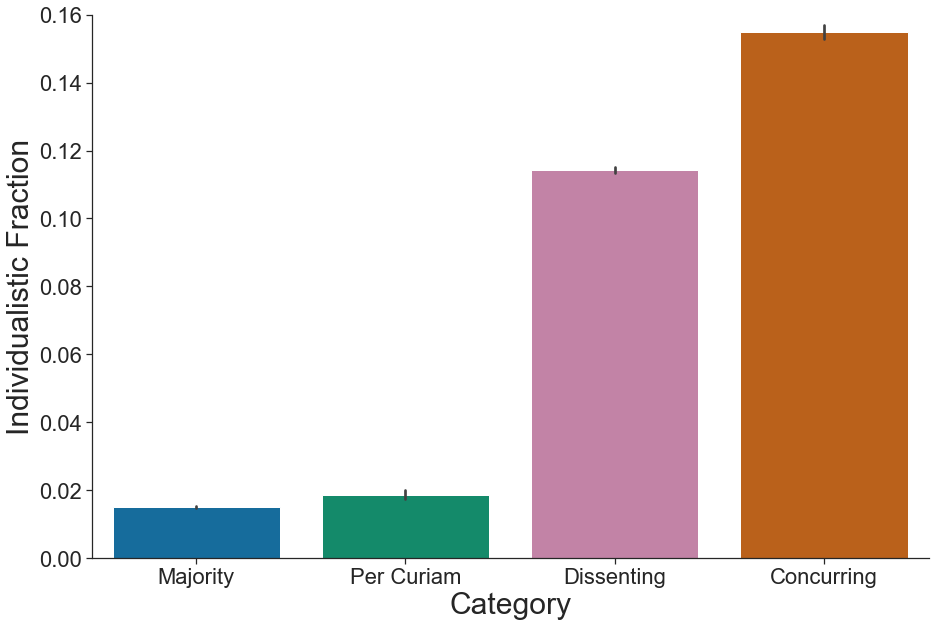

In [7]:
plot_ratio(df, y_value = "individualistic", y_axis= "Individualistic Fraction")

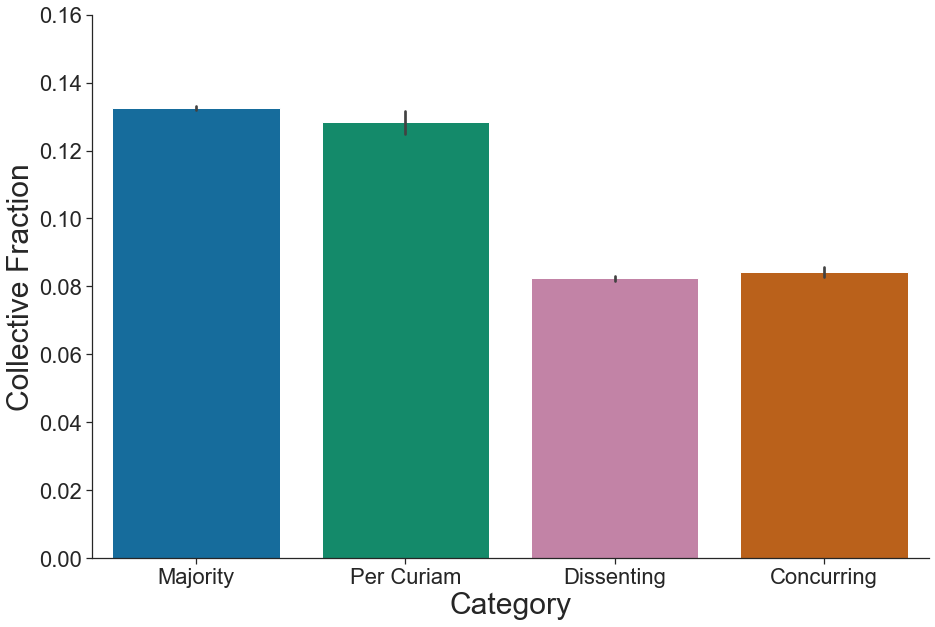

In [8]:
plot_ratio(df, y_value = "collective", y_axis= "Collective Fraction")

In [9]:
# drop error names
per_curiam = ["per_curiam", "Justice Vinson"]
df_filtered = df[~df['author'].isin(per_curiam)]
df_filtered = df_filtered.drop(df_filtered[(df_filtered['author'] == "Justice Jackson") & (df_filtered['year'] == 1964)].index)


In [10]:
# SPLIT SCALIA,  THOMAS, KENNEDY, GINSBURG, BREYER, SOUTER, STEVENS
df_filtered["author"].replace("Justice ",'',regex=True, inplace = True)

roberts_court = pd.DataFrame(["Stevens", "O'Connor", "Scalia", "Kennedy", "Souter", "Thomas", "Ginsburg", "Breyer"])
roberts_court["roberts_justice"] = "Rehnquist - Roberts Court"
roberts_court = roberts_court.rename(columns = {0:"author"})

only_roberts = pd.DataFrame(["Roberts", "Alito", "Sotomayor", "Kagan", "Gorsuch", "Kavanaugh", "Barrett"])
only_roberts["roberts_justice"] = "Roberts Court"
only_roberts = only_roberts.rename(columns = {0:"author"})

# stack them
roberts_frames = [only_roberts, roberts_court]
roberts_combined_df = pd.concat(roberts_frames)

# combine with filter
df_filtered = df_filtered.merge(roberts_combined_df, on = "author", how = "left")
df_filtered["roberts_justice"] = df_filtered["roberts_justice"].fillna("Not Roberts Court")



In [11]:
def check_if_roberts(author, year, roberts_justice):
    if roberts_justice == "Rehnquist - Roberts Court":
        if year > 2006:
            new_author = "post-" + author
        else:
            new_author = "pre-" + author
    else:
        new_author = author
    return new_author

In [12]:
def change_roberts_col(author, year, roberts_justice):
    if roberts_justice == "Rehnquist - Roberts Court":
        if year > 2006:
            court = "Bridging Justice (post-Rehnquist)"
        else:
            court = "Bridging Justice (pre-Rehnquist)"
    else:
        court = roberts_justice
    return court

In [13]:
df_filtered['split_author'] = df_filtered.apply(lambda x: check_if_roberts(x['author'], x['year'], x["roberts_justice"]), axis=1)

In [14]:
df_filtered.author.unique()

array(['Sotomayor', 'Breyer', 'Barrett', 'Kagan', 'Alito', 'Roberts',
       'Kavanaugh', 'Thomas', 'Gorsuch', 'Douglas', 'Kennedy', 'Ginsburg',
       'White', 'Scalia', 'Frankfurter', 'Rutledge', 'Fortas', 'Stewart',
       'Clark', 'Harlan', 'Reed', 'Warren', 'Blackmun', 'Burger',
       'Brennan', "O'Connor", 'Marshall', 'Stevens', 'Powell',
       'Whittaker', 'Jackson', 'Rehnquist', 'Black', 'Souter', 'Murphy',
       'Burton', 'Minton', 'Goldberg'], dtype=object)

In [15]:
df_filtered['court'] = df_filtered.apply(lambda x: change_roberts_col(x['author'], x['year'], x["roberts_justice"]), axis=1)

In [16]:
df_filtered.court.unique()

array(['Roberts Court', 'Bridging Justice (post-Rehnquist)',
       'Not Roberts Court', 'Bridging Justice (pre-Rehnquist)'],
      dtype=object)

In [17]:
# of all of the monologic voice that they use, how much of it is individualistic vs collective? 
# of all of the sentences they write, how probable is it that a sentence will be individualistic? 

df_indi = df_filtered.groupby(['opinion_num', 'category','split_author', 'case', 'year', 'court', 'roberts_justice'])['individualistic'].mean().reset_index()
df_collective = df_filtered.groupby(['opinion_num', 'category','split_author', 'case', 'year',  'court', 'roberts_justice'])['collective'].mean().reset_index()


In [18]:
# then get author's individualistic mean by opinion
df_author_indi = pd.DataFrame(df_indi.groupby(['split_author', 'court'])['individualistic'].mean()).reset_index()
df_author_collective = pd.DataFrame(df_collective.groupby(['split_author', 'court'])['collective'].mean()).reset_index()


In [19]:
# this can become a heatmap
combined_means = pd.merge(df_author_indi, df_author_collective, on = "split_author")

In [20]:
combined_means

,split_author,court_x,individualistic,court_y,collective
0,Alito,Roberts Court,0.075806,Roberts Court,0.111179
1,Barrett,Roberts Court,0.103035,Roberts Court,0.143202
2,Black,Not Roberts Court,0.132208,Not Roberts Court,0.111026
3,Blackmun,Not Roberts Court,0.139051,Not Roberts Court,0.080504
4,Brennan,Not Roberts Court,0.101361,Not Roberts Court,0.108346
5,Burger,Not Roberts Court,0.091773,Not Roberts Court,0.109337
6,Burton,Not Roberts Court,0.047547,Not Roberts Court,0.096643
7,Clark,Not Roberts Court,0.060685,Not Roberts Court,0.119693
8,Douglas,Not Roberts Court,0.079454,Not Roberts Court,0.114608
9,Fortas,Not Roberts Court,0.106020,Not Roberts Court,0.113117


In [21]:
combined_means = combined_means.set_index('split_author')
combined_means.sort_values(by = "collective")

,court_x,individualistic,court_y,collective
split_author,,,,
post-Kennedy,Bridging Justice (post-Rehnquist),0.041849,Bridging Justice (post-Rehnquist),0.059400
Whittaker,Not Roberts Court,0.103733,Not Roberts Court,0.078094
Goldberg,Not Roberts Court,0.113080,Not Roberts Court,0.079135
Rutledge,Not Roberts Court,0.137988,Not Roberts Court,0.079604
Blackmun,Not Roberts Court,0.139051,Not Roberts Court,0.080504
Sotomayor,Roberts Court,0.083243,Roberts Court,0.084677
post-Ginsburg,Bridging Justice (post-Rehnquist),0.055023,Bridging Justice (post-Rehnquist),0.086019
Stewart,Not Roberts Court,0.101020,Not Roberts Court,0.090218
Harlan,Not Roberts Court,0.199640,Not Roberts Court,0.095825


In [22]:
combined_means = combined_means[combined_means.index != "Harlan"]

In [23]:
def scatter_justices_contrast_cols(df, majority_col, minority_col, hue_col):
    plt.figure(figsize=(15,15))
    palette ={"Roberts Court": "#d7b3db", "Not Roberts Court":"#c6e4e1", "Bridging Justice (pre-Rehnquist)":"#43A59D", "Bridging Justice (post-Rehnquist)": "#9d43a5"} 


    g = sns.scatterplot(data=df, 
                    x=majority_col, 
                    y=minority_col, 
                    s = 200, 
                    hue = hue_col, 
                    #style = style_col,
                    palette = palette
                    )

    for i in range(df.shape[0]):
        plt.text(x=df.collective[i]+.0005,y=df.individualistic[i]+.001,s=df.index[i], 
             fontdict=dict(color='black', size=12))
             
    connections = [
        ["pre-Scalia", "post-Scalia"], 
        ["pre-Ginsburg", "post-Ginsburg"], 
        ["pre-Stevens", "post-Stevens"], 
        ["pre-Kennedy", "post-Kennedy"], 
        ["pre-Souter", "post-Souter"],
        ["pre-Thomas", "post-Thomas"],
        ["pre-Breyer", "post-Breyer"]
        ]

    for name in connections:
        x_point_1 = combined_means[combined_means.index == name[0]].collective.tolist()[0]
        y_point_1 = combined_means[combined_means.index == name[0]].individualistic.tolist()[0]
        x_point_2 = combined_means[combined_means.index == name[1]].collective.tolist()[0]
        y_point_2 = combined_means[combined_means.index == name[1]].individualistic.tolist()[0]
        x_values = [x_point_1, x_point_2]
        y_values = [y_point_1, y_point_2]
        plt.plot(x_values, y_values, linestyle = '--', color = 'black', alpha = .2, markersize = 2)  

    
    point1 = [.01, .01]
    point2 = [.275, .275]

    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    
    plt.xlabel("Collective Voice Fraction")
    plt.ylabel("Individualistic Voice Fraction")

    legend = plt.legend(loc='upper left', title='')


    plt.xlim(0.02, .16)
    plt.ylim(0.02, .16)
    
    
    plt.savefig(output_path + '/by_justice_scatter', dpi = 300);

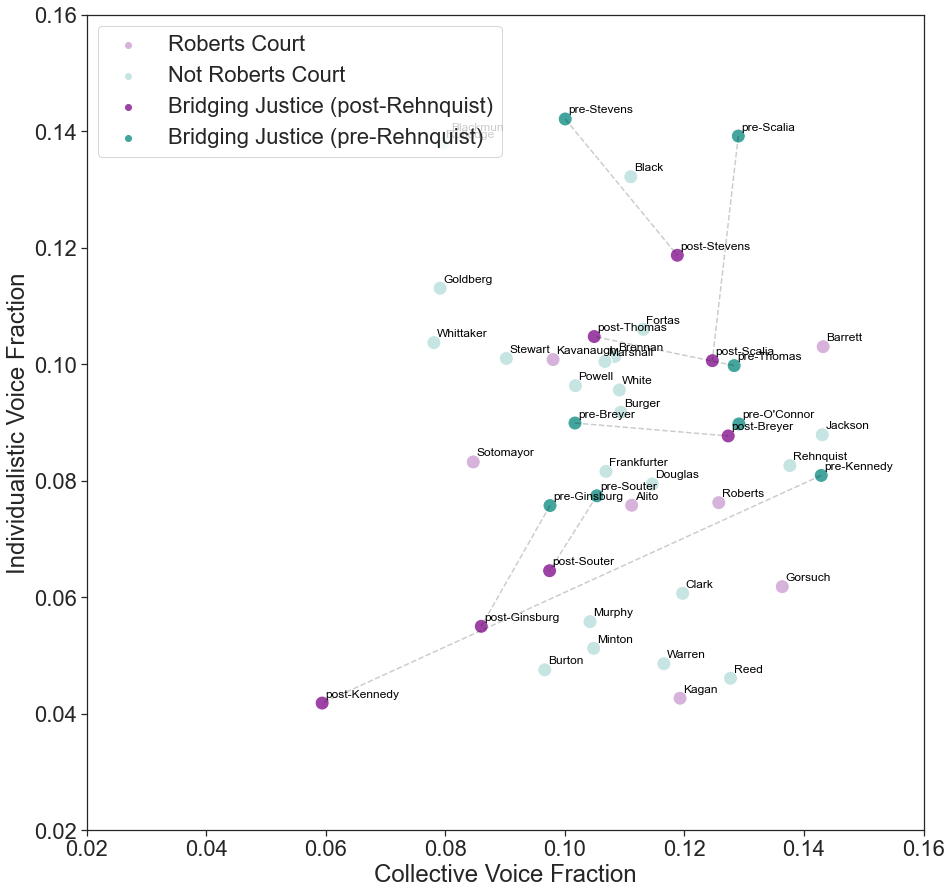

In [24]:
scatter_justices_contrast_cols(combined_means, 'collective', 'individualistic',  "court_y")

In [25]:
# changes over time
def plot_sentences_over_years(df):
    sns.set(style='ticks', font_scale=1.2)
    plt.figure(figsize=(14,10))
    sns.lineplot(data=df,
                x="year", 
                y='monologic_prediction',
                estimator=mean, 
                color='cornflowerblue')
    sns.lineplot(data=df,
            x="year", 
            y='individualistic',
            estimator=mean, 
            color='red')
    sns.lineplot(data=df,
            x="year", 
            y='collective',
            estimator=mean, 
            color='green')

    # set xlim
    chief_years = [1946, 1953, 1969, 1986, 2005]
    chief_names = ["Vinson", "Warren", "Burger", "Rehnquist", "Roberts"]
    for y, n in zip(chief_years, chief_names):
        plt.axvline(y, color='0.8')
        plt.text(x=y+.5, y=.21, s=n, color='black')
    plt.xticks(np.arange(1945, 2022, 10))
    plt.xlabel('Case Year', labelpad=20, fontsize = 17)
    plt.ylabel('Monologic Concentration', labelpad=20, fontsize = 17)

    import matplotlib.patches as mpatches
    monologic_patch = mpatches.Patch(color='cornflowerblue', label='Monologic Overall')
    coll_patch = mpatches.Patch(color='green', label='Collective')
    indi_patch = mpatches.Patch(color='red', label='Individualistic')

    plt.legend(handles=[monologic_patch, coll_patch, indi_patch],  loc='lower left', prop={'size': 20})
    plt.tight_layout()
    sns.despine()
    plt.savefig(output_path + '/over_time', dpi = 300)
    plt.show()

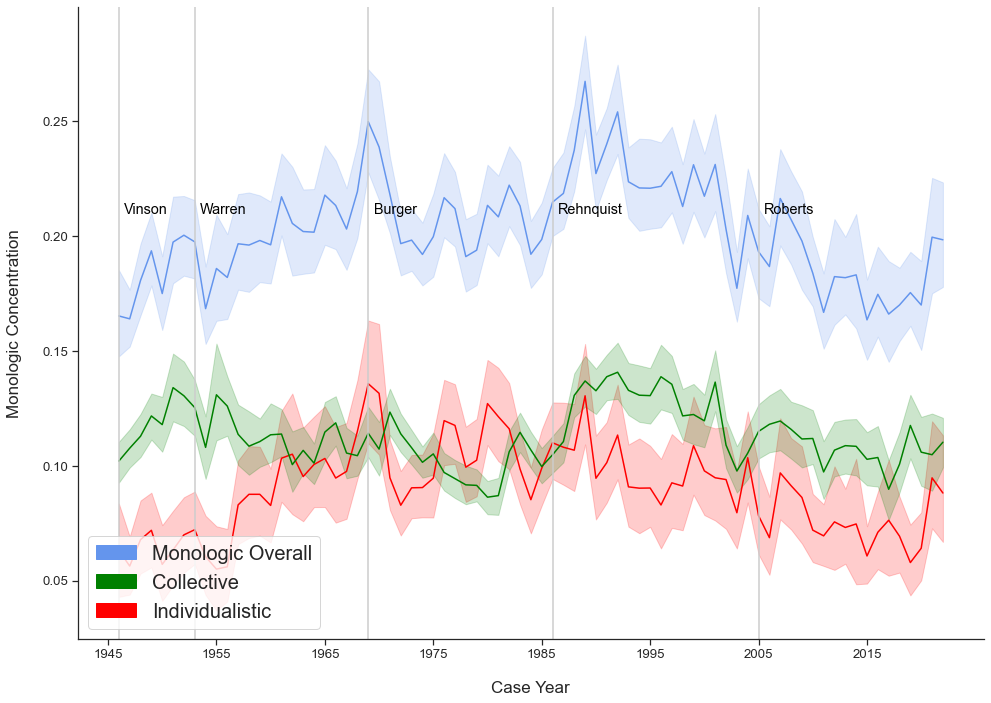

In [26]:
plot_sentences_over_years(opinion_means)

In [27]:
# plot_sentences_over_years(df)

In [28]:
# opinion_means = pd.DataFrame(df.groupby(['opinion_num', 'category','author', 'case', 'length', 'year'])['individualistic', 'collective', 'monologic_prediction'].mean()).reset_index()
author_means = pd.DataFrame(opinion_means.groupby(['author', 'year'])['individualistic', 'collective'].mean()).reset_index()

/var/folders/lp/x4djrvvn0pg2br3sp0y85wkr0000gn/T/ipykernel_38183/1981155824.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  author_means = pd.DataFrame(opinion_means.groupby(['author', 'year'])['individualistic', 'collective'].mean()).reset_index()


In [29]:
author_means["individualistic"].corr(author_means["collective"])

-0.3454130974500024

In [30]:
author_overall_aves = opinion_means.groupby(["author"])["individualistic", "collective"].mean().reset_index()
author_overall_aves["individualistic"].corr(author_overall_aves["collective"])

/var/folders/lp/x4djrvvn0pg2br3sp0y85wkr0000gn/T/ipykernel_38183/3224919530.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  author_overall_aves = opinion_means.groupby(["author"])["individualistic", "collective"].mean().reset_index()


-0.45929002125095697

In [31]:
import scipy.stats
r, p = scipy.stats.pearsonr(author_overall_aves["individualistic"], author_overall_aves["collective"])
print(r)
print(p)

-0.4592900212509571
0.0028709691046993426


In [32]:
opinion_means.to_csv(os.path.join(os.getcwd(), 'Data', 'opinion_means.csv'))

In [33]:
author_means = author_means[author_means["year"]>2005]
author_means = author_means[author_means["author"] != "per_curiam"]

In [34]:
opinion_means_since_2017 = opinion_means[opinion_means["year"]>2016]
opinion_means_since_2017 = opinion_means_since_2017[opinion_means_since_2017["author"] != "Ginsburg"]
opinion_means_since_2017 = opinion_means_since_2017[opinion_means_since_2017["author"] != "Kennedy"]

opinion_means_since_2017 = opinion_means_since_2017[opinion_means_since_2017["author"] != "per_curiam"]
opinion_means_since_2017 = opinion_means_since_2017[opinion_means_since_2017["author"] != "Justice Kennedy"]


opinion_means_since_2017 = opinion_means_since_2017.groupby(['author'])['individualistic', 'collective'].mean().reset_index().sort_values(by = "individualistic", ascending = False)

/var/folders/lp/x4djrvvn0pg2br3sp0y85wkr0000gn/T/ipykernel_38183/3732974459.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  opinion_means_since_2017 = opinion_means_since_2017.groupby(['author'])['individualistic', 'collective'].mean().reset_index().sort_values(by = "individualistic", ascending = False)


In [35]:
opinion_means_since_2017

,author,individualistic,collective
9,Justice Thomas,0.103510,0.108885
1,Justice Barrett,0.103035,0.143202
6,Justice Kavanaugh,0.100824,0.098027
8,Justice Sotomayor,0.095944,0.051983
0,Justice Alito,0.078709,0.112986
2,Justice Breyer,0.075802,0.136988
4,Justice Gorsuch,0.061833,0.136361
7,Justice Roberts,0.059390,0.141297
5,Justice Kagan,0.050440,0.101712
3,Justice Ginsburg,0.036223,0.074511


In [36]:
opinion_means_since_2017.author.replace("Justice ",'',regex=True, inplace = True)
opinion_means_since_2017 = opinion_means_since_2017.set_index("author")

In [37]:
# opinion_means_since_2017 = opinion_means_since_2017[opinion_means_since_2017["author"] != "Ginsburg"]

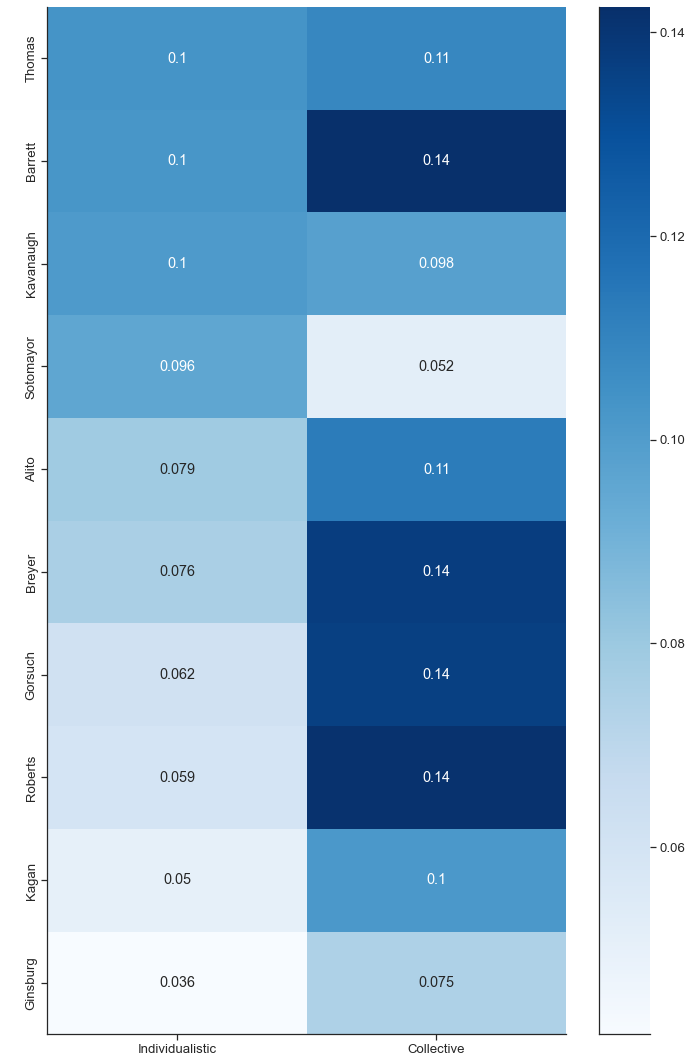

In [38]:
# opinion_means_since_2017.author.replace("Justice ",'',regex=True, inplace = True)

def plot_last_five_years(df):
    sns.set(style='ticks', font_scale=1.2)
    plt.subplots(figsize=(10,15)) 
    mask = df.isnull()
    column_labels = ["Individualistic", "Collective"]
    cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True, reverse=True)
    graph = sns.heatmap(df, 
                robust=True,
                mask=mask,
                xticklabels=column_labels,
                cmap = "Blues",
                annot = True
               )
    graph.set_facecolor('lightgrey')
    plt.ylabel(' ')
    plt.tight_layout()
    sns.despine()
    # plt.savefig(output_path + '/by_justice', dpi = 300)
    plt.show()
    
plot_last_five_years(opinion_means_since_2017)

In [39]:
def plot_authors_over_years(df, mono_col):
    sns.set(style='ticks', font_scale=1.2)
    plt.figure(figsize=(20,10))
    sns.lineplot(data=df,
                x="year", 
                y=mono_col,
                hue = "author")
    plt.legend([])
    plt.show()

In [40]:
opinion_means_late = opinion_means[opinion_means["year"]>2005]
opinion_means_late = opinion_means_late[opinion_means_late["author"] != "per_curiam"]


opinion_means_late.author.replace("Justice ",'',regex=True, inplace = True)
grouped_year = pd.DataFrame(opinion_means_late.groupby(['author', 'year'])['individualistic', 'collective'].mean())
grouped_year_df = grouped_year.reset_index(level=['year'])
author_by_year_indi = pd.pivot_table(data=grouped_year_df,index=['author'], columns = ["year"], values = ["individualistic"])
author_by_year_coll = pd.pivot_table(data=grouped_year_df,index=['author'], columns = ["year"], values = ["collective"])

/var/folders/lp/x4djrvvn0pg2br3sp0y85wkr0000gn/T/ipykernel_38183/2170110010.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_year = pd.DataFrame(opinion_means_late.groupby(['author', 'year'])['individualistic', 'collective'].mean())


In [41]:
def plot_heatmap_by_year(df, include_cj = False):
    sns.set(style='ticks', font_scale=1.7)
    plt.subplots(figsize=(15,10)) 
    mask = df.isnull()
    graph = sns.heatmap(df, 
                robust=True,
                mask=mask,
                cmap = sns.cubehelix_palette(rot=-.4)
               )
    graph.set_facecolor('gainsboro')
    # plt.xticks(np.arange(-1, 76, 10),
    #            ['1945', '1955', '1965', '1975', '1985', '1995', '2005', '2015'], 
    #            rotation = 360,
    #            fontsize = 20
    #           )
    plt.xlabel('Year')
    plt.ylabel('')
    plt.tight_layout()
    sns.despine()
    # plt.savefig(output_path + '/heatmap_over_time', dpi = 300)
    plt.show()

In [42]:
author_order = ["O'Connor", "Souter", "Stevens", "Scalia", "Kennedy", "Ginsburg", "Breyer", "Thomas", "Alito", "Roberts", "Sotomayor", "Kagan", "Gorsuch", "Kavanaugh", "Barrett"]

In [43]:
author_by_year_indi = author_by_year_indi.loc[author_order]
author_by_year_coll = author_by_year_coll.loc[author_order]


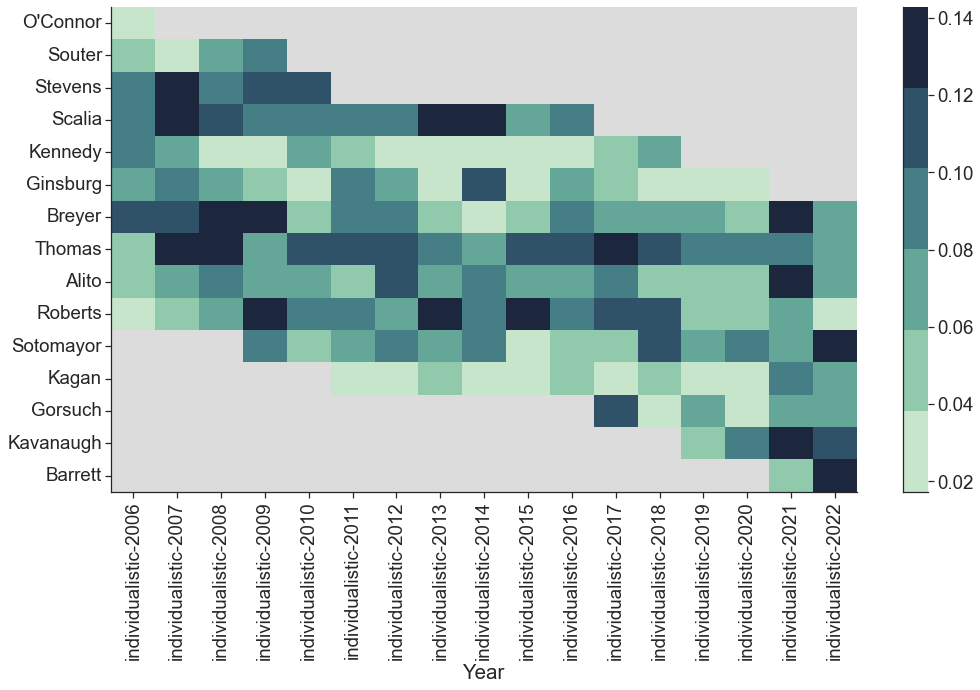

In [44]:
plot_heatmap_by_year(author_by_year_indi)

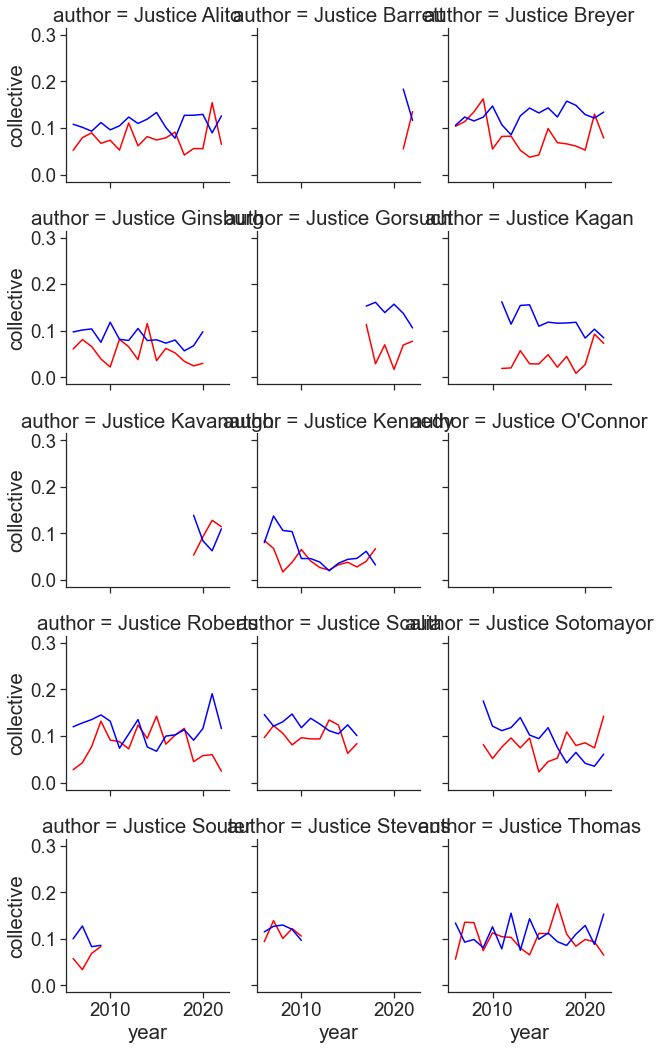

<Figure size 1440x720 with 0 Axes>

In [45]:
g = sns.FacetGrid(author_means, col="author", col_wrap=3)
plt.figure(figsize=(20,10))

g.map(sns.lineplot, "year", "individualistic", color = "red")
g.map(sns.lineplot, "year", "collective", color = "blue")

plt.show()

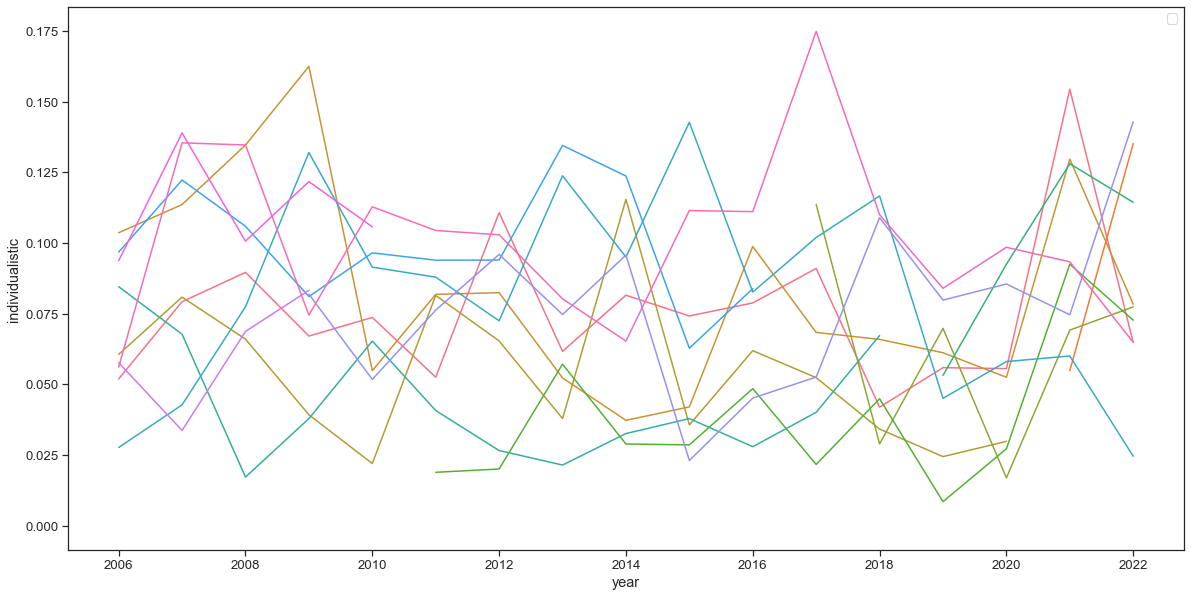

In [46]:
plot_authors_over_years(author_means, mono_col="individualistic")

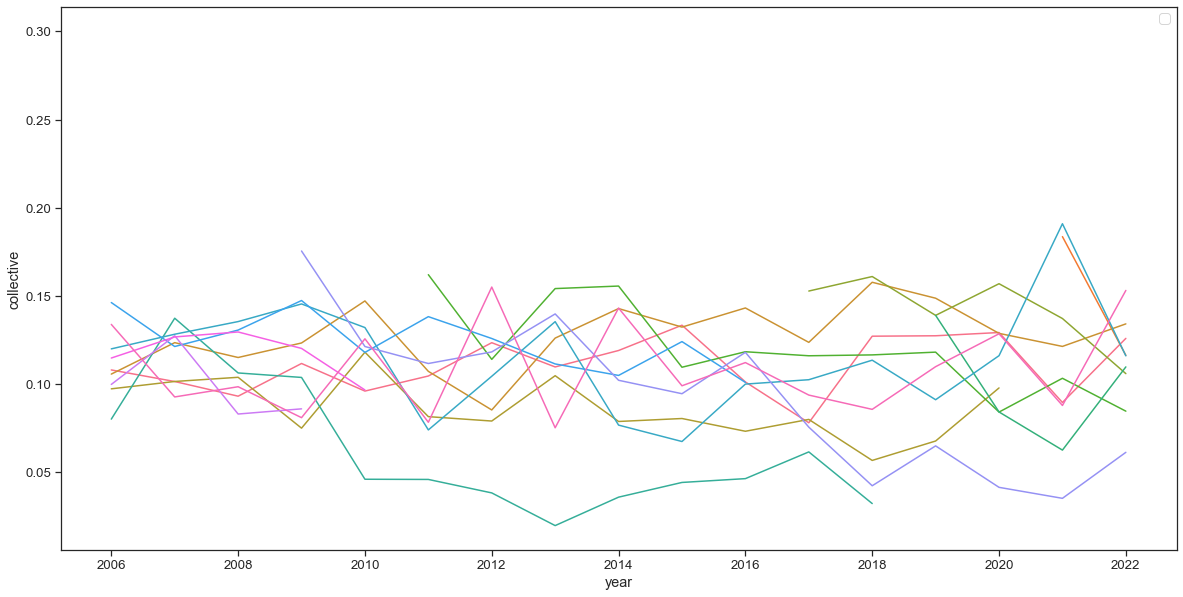

In [47]:
plot_authors_over_years(author_means, mono_col="collective")

In [48]:
author_means[author_means["year"] == 2022]

,author,year,individualistic,collective
16,Justice Alito,2022,0.064793,0.125890
18,Justice Barrett,2022,0.135175,0.116269
132,Justice Breyer,2022,0.078317,0.134109
272,Justice Gorsuch,2022,0.077375,0.105885
311,Justice Kagan,2022,0.072674,0.084602
315,Justice Kavanaugh,2022,0.114391,0.109704
489,Justice Roberts,2022,0.024535,0.115978
538,Justice Sotomayor,2022,0.142855,0.061251
647,Justice Thomas,2022,0.064844,0.153078


## Author Information

In [49]:
roberts_court = pd.DataFrame(["Stevens", "O'Connor", "Scalia", "Kennedy", "Souter", "Thomas", "Ginsburg", "Breyer", "Roberts", "Alito", "Sotomayor", "Kagan", "Gorsuch", "Kavanaugh", "Barrett"])
roberts_court["roberts_justice"] = "Roberts Court"

roberts_court = roberts_court.rename(columns = {0:"author"})


In [50]:
collective_by_opinion = pd.DataFrame(df_filtered.groupby(['opinion_num', 'author', 'year'])['collective'].mean()).reset_index()
individualistic_by_opinion = pd.DataFrame(df_filtered.groupby(['opinion_num', 'author', 'year'])['individualistic'].mean()).reset_index()
overall_by_opinion =  pd.DataFrame(df_filtered.groupby(['opinion_num', 'author', 'year'])['monologic_prediction'].mean()).reset_index()

In [51]:
zscore = lambda x: (x - x.mean()) / x.std()

# group by opinion category and find z scores
collective_by_opinion.insert(1, 'z-score-collective', collective_by_opinion['collective'].transform(zscore))
individualistic_by_opinion.insert(1, 'z-score-individualistic', individualistic_by_opinion["individualistic"].transform(zscore))
overall_by_opinion.insert(1, 'z-score-overall', overall_by_opinion["monologic_prediction"].transform(zscore))

# calculate overall mean of opinion z scores
author_zscores_collective_overall = pd.DataFrame(collective_by_opinion.groupby('author')['z-score-collective'].mean()).reset_index()
author_zscores_individualistic_overall = pd.DataFrame(individualistic_by_opinion.groupby('author')['z-score-individualistic'].mean()).reset_index()
author_zscores_overall = pd.DataFrame(overall_by_opinion.groupby('author')['z-score-overall'].mean()).reset_index()


In [52]:
combined_z_scores = author_zscores_overall.merge(author_zscores_collective_overall, on = "author")
combined_z_scores = combined_z_scores.merge(author_zscores_individualistic_overall, on = "author")
combined_z_scores["author"].replace("Justice ",'',regex=True, inplace = True)
combined_z_scores = combined_z_scores.set_index("author")

combined_z_scores
combined_z_scores = combined_z_scores.sort_values(by=['z-score-individualistic'], ascending=False)

In [53]:
combined_z_scores["mono_diffs"] = abs(combined_z_scores["z-score-collective"] - combined_z_scores["z-score-individualistic"])

In [54]:
combined_z_scores = combined_z_scores.sort_values(by=['z-score-individualistic'], ascending=False)

In [55]:
combined_z_scores

,z-score-overall,z-score-collective,z-score-individualistic,mono_diffs
author,,,,
Harlan,0.618813,-0.184696,0.686575,0.871271
Stevens,0.230225,-0.109985,0.276957,0.386942
Blackmun,0.068726,-0.387773,0.267770,0.655544
Rutledge,0.054494,-0.399704,0.260417,0.660121
Black,0.240309,0.016794,0.220463,0.203669
Scalia,0.341277,0.240397,0.200167,0.040229
Goldberg,-0.129404,-0.405927,0.088250,0.494177
Fortas,0.065688,0.044515,0.039443,0.005072
Whittaker,-0.204687,-0.419722,0.023634,0.443357


In [56]:
combined_z_scores = combined_z_scores[["z-score-overall", "z-score-collective", "z-score-individualistic"]]

In [57]:
def plot_heatmap_by_category(df):
    sns.set(style='ticks', font_scale=1.2)
    plt.subplots(figsize=(10,15)) 
    mask = df.isnull()
    column_labels = ["Overall", "Collective", "Individualistic"]
    cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True, reverse=True)
    graph = sns.heatmap(df, 
                robust=True,
                mask=mask,
                xticklabels=column_labels,
                cmap = "Blues",
                annot = True
               )
    graph.set_facecolor('lightgrey')
    plt.ylabel(' ')
    plt.tight_layout()
    sns.despine()
    plt.savefig(output_path + '/by_justice', dpi = 300)
    plt.show()

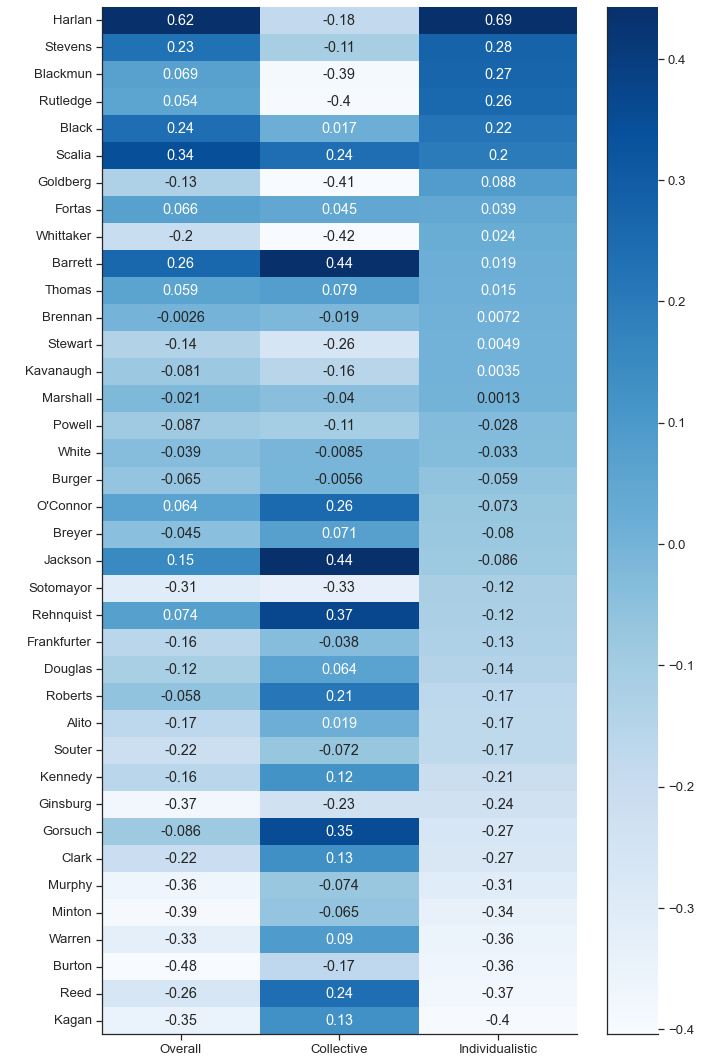

In [58]:
plot_heatmap_by_category(combined_z_scores)

In [59]:
author_overall_individualistic = pd.DataFrame(individualistic_by_opinion.groupby(['author'])["individualistic"].mean()).reset_index()
author_overall_collective = pd.DataFrame(collective_by_opinion.groupby(['author'])["collective"].mean()).reset_index()

combined_overall_types = author_overall_collective.merge(author_overall_individualistic, on = "author")

In [60]:
author_by_year_individualistic = df.groupby(['author','year', 'category'], as_index=False)['individualistic'].mean()
author_by_year_collective = df.groupby(['author','year', 'category'], as_index=False)['collective'].mean()

In [61]:
def trends_over_years_by_author(df, year_col, prediction_col, category_col):
    sns.set(style='ticks', font_scale=2)
    colorblind = ["#0072B2", "#009E73", "#D55E00","#CC79A7"]
    palette ={"Majority": colorblind[0], "Per Curiam": colorblind[1], "Concurring": colorblind[2], "Dissenting": colorblind[3]} 

    sns.lmplot(data=df, 
               x=year_col, 
               y=prediction_col, 
               hue=category_col, 
               palette = palette, 
               lowess = True, 
               height=8, 
               aspect=1.7, 
               scatter_kws={'alpha':0.3},
               line_kws={'lw': 4},
               legend = False)

    leg = plt.legend(title="", loc = 2)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    plt.ylim(0, .5)
    plt.xlabel('Year', fontsize = 20)
    plt.ylabel('Monologic Fraction', fontsize = 20)
    plt.savefig(output_path + '/'+prediction_col+'_scatter_over_time', dpi = 300)
    plt.show()

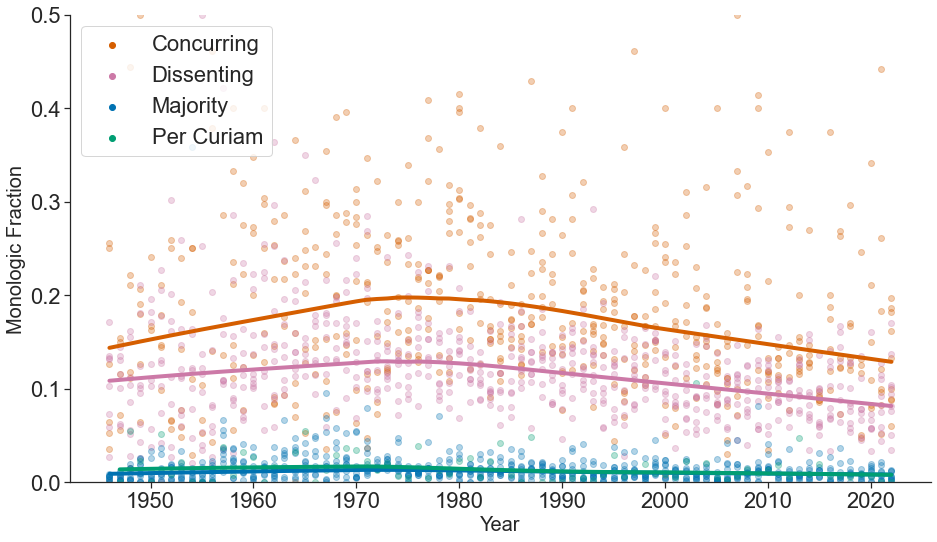

In [62]:
trends_over_years_by_author(author_by_year_individualistic, year_col = "year", prediction_col="individualistic", category_col="category")

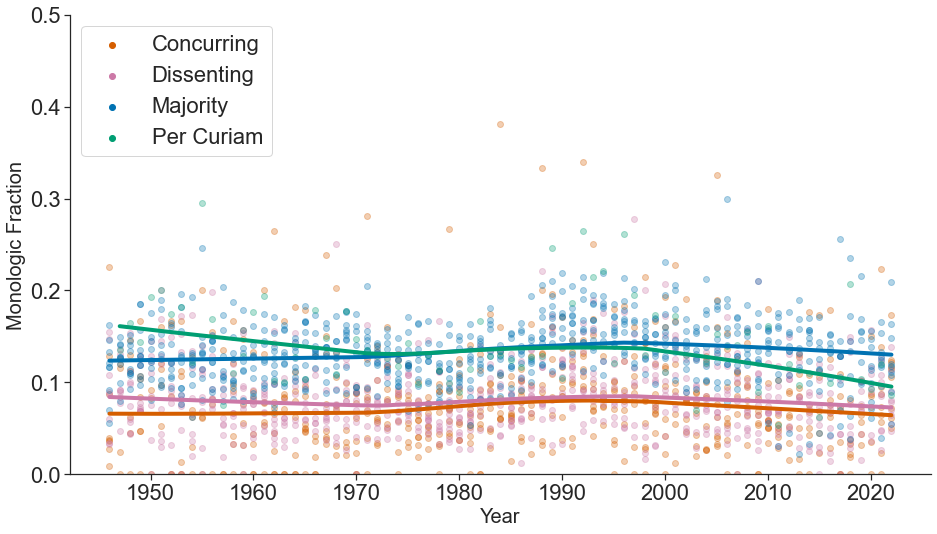

In [63]:
trends_over_years_by_author(author_by_year_collective, "year", "collective", "category")

In [64]:
def plot_heatmap_by_category(df):
    sns.set(style='ticks', font_scale=2)
    plt.subplots(figsize=(15,20)) 
    mask = df.isnull()
    column_labels = ["Individualistic", "Collective"]
    cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True, reverse=True)
    graph = sns.heatmap(df, 
                robust=True,
                mask=mask,
                xticklabels=column_labels,
                #cmap = cmap
                cmap = "Blues"
               )
    graph.set_facecolor('lightgrey')
    #plt.xlabel('Category')
    plt.ylabel(' ')
    #plt.title("Percentage Monologic Voice by Category")
    plt.tight_layout()
    sns.despine()
    plt.savefig(output_path + '/type_by_justice', dpi = 300)
    plt.show()

In [65]:
individual_by_opinion = df_filtered.groupby(['opinion_num', 'year'], as_index=False)['individualistic'].mean()
collective_by_opinion = df_filtered.groupby(['opinion_num', 'year'], as_index=False)['collective'].mean()

In [66]:
# merge per opinion with metadata
def create_subsets_by_chief_justice(per_opinion):
    vinson_court = per_opinion[per_opinion["year"] <= 1953]
    warren_court = per_opinion[(per_opinion["year"] >= 1954) & (per_opinion["year"] <= 1968)]
    burger_court = per_opinion[(per_opinion["year"] >= 1969) & (per_opinion["year"] <= 1985)]
    rehnquist_court = per_opinion[(per_opinion["year"] >= 1986) & (per_opinion["year"] <= 2005)]
    roberts_court = per_opinion[(per_opinion["year"] >= 2006)]

    return vinson_court, warren_court, burger_court, rehnquist_court, roberts_court

In [67]:
ind_vinson_court, ind_warren_court, ind_burger_court, ind_rehnquist_court, ind_roberts_court = create_subsets_by_chief_justice(individual_by_opinion)
col_vinson_court, col_warren_court, col_burger_court, col_rehnquist_court, col_roberts_court = create_subsets_by_chief_justice(collective_by_opinion)

In [68]:
from statistics import mean, stdev
from math import sqrt

def cohens_d(values_1, values_2):
    cohens_d = (mean(values_1) - mean(values_2)) / (sqrt((stdev(values_1) ** 2 + stdev(values_2) ** 2) / 2))
    return cohens_d

def summary_stats(df, col):
    col_ave = round(mean(df[col]), 3)
    col_std = round(stdev(df[col]), 3)

    return col_ave, col_std
    
    

In [72]:
ind_vins_ave, ind_vins_std = summary_stats(ind_vinson_court, col = "individualistic")
ind_war_ave, ind_war_std = summary_stats(ind_warren_court, col = "individualistic")
ind_bur_ave, ind_bur_std = summary_stats(ind_burger_court, col = "individualistic")
ind_reh_ave, ind_reh_std = summary_stats(ind_rehnquist_court, col = "individualistic")
ind_rob_ave, ind_rob_std = summary_stats(ind_roberts_court, col = "individualistic")

In [73]:
col_vins_ave, col_vins_std = summary_stats(col_vinson_court, col = "collective")
col_war_ave, col_war_std = summary_stats(col_warren_court, col = "collective")
col_bur_ave, col_bur_std = summary_stats(col_burger_court, col = "collective")
col_reh_ave, col_reh_std = summary_stats(col_rehnquist_court, col = "collective")
col_rob_ave, col_rob_std = summary_stats(col_roberts_court, col = "collective")

In [74]:
stats_data = [["vinson", ind_vins_ave, ind_vins_std, col_vins_ave, col_vins_std], ["warren", ind_war_ave, ind_war_std, col_war_ave, col_war_std], ["burger", ind_bur_ave, ind_bur_std, col_bur_ave, col_bur_std], 
["rehnquist", ind_reh_ave, ind_reh_std, col_reh_ave, col_reh_std], ["roberts", ind_rob_ave, ind_rob_std, col_rob_ave, col_rob_std]]

In [75]:
court_stats_df = pd.DataFrame(stats_data, columns = ["Chief Justice", "Individualistic Mean", "Individualistic Standard Deviation", "Collective Mean", "Collective Standard Deviation"])

In [76]:
court_stats_df

,Chief Justice,Individualistic Mean,Individualistic Standard Deviation,Collective Mean,Collective Standard Deviation
0,vinson,0.070,0.117,0.114,0.074
1,warren,0.101,0.152,0.108,0.080
2,burger,0.114,0.156,0.100,0.070
3,rehnquist,0.104,0.147,0.122,0.078
4,roberts,0.081,0.113,0.108,0.074


In [77]:
court_stats_df.to_csv(os.path.join(output_path, "court_stats.csv"))

### Rehnquist - Roberts Justices

In [78]:
def remove_hyphen(string_to_split):
    name = string_to_split.split("-")[1]
    return name

In [79]:
roberts_only_group = df_filtered[df_filtered["roberts_justice"] == "Roberts Court"]
roberts_only_group.author.unique()

array(['Sotomayor', 'Barrett', 'Kagan', 'Alito', 'Roberts', 'Kavanaugh',
       'Gorsuch'], dtype=object)

In [80]:
rehnquist_roberts_group = df_filtered[df_filtered["roberts_justice"]=="Rehnquist - Roberts Court"]
rehnquist_roberts_group["split_author"] = rehnquist_roberts_group["split_author"].apply(remove_hyphen)
individual_rehn_rob = rehnquist_roberts_group.groupby(['split_author','opinion_num', 'year'], as_index=False)['individualistic'].mean()
collective_rehn_rob = rehnquist_roberts_group.groupby(['split_author','opinion_num', 'year'], as_index=False)['collective'].mean()

/var/folders/lp/x4djrvvn0pg2br3sp0y85wkr0000gn/T/ipykernel_38183/2353310143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rehnquist_roberts_group["split_author"] = rehnquist_roberts_group["split_author"].apply(remove_hyphen)


### Cohen's d effect size

In [81]:
def get_effect_size(df1, df2, col, df1_name, df2_name):
    effect = round(cohens_d(df1[col].to_list(), df2[col].to_list()), 3)

    return effect


In [82]:
# OVERALL STATS
rehnquist_roberts_group = rehnquist_roberts_group[rehnquist_roberts_group["author"] != "O'Connor"]

In [83]:
rehnquist_roberts_group = rehnquist_roberts_group.groupby(['opinion_num', 'category', 'author', 'case', 'year', 'split_author'])['individualistic', 'collective'].mean().reset_index()

/var/folders/lp/x4djrvvn0pg2br3sp0y85wkr0000gn/T/ipykernel_38183/1107642800.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rehnquist_roberts_group = rehnquist_roberts_group.groupby(['opinion_num', 'category', 'author', 'case', 'year', 'split_author'])['individualistic', 'collective'].mean().reset_index()


In [84]:
# indi_author_only = individual_rehn_rob[individual_rehn_rob["split_author"] == name]
indi_before_rehnquist = individual_rehn_rob[individual_rehn_rob["year"] < 2006]
indi_before_average, indi_before_std = summary_stats(indi_before_rehnquist, col = "individualistic")
indi_after_rehnquist = individual_rehn_rob[individual_rehn_rob["year"] >= 2005]
indi_after_average, indi_after_std = summary_stats(indi_after_rehnquist, col = "individualistic")
ind_stat, ind_p = ttest_ind(indi_before_rehnquist["individualistic"], indi_after_rehnquist["individualistic"])
if ind_p > 0.05:
    ind_sig = "NS"
else:
    ind_sig = "S"
indi_effect = round(cohens_d(indi_before_rehnquist['individualistic'].to_list(), indi_after_rehnquist['individualistic'].to_list()), 3)


# group as collective before and after rehnquist; get effect size
coll_before_rehnquist = collective_rehn_rob[collective_rehn_rob["year"] < 2006]
coll_before_average, coll_before_std = summary_stats(coll_before_rehnquist, col = "collective")
coll_after_rehnquist = collective_rehn_rob[collective_rehn_rob["year"] >= 2005]
coll_after_average, coll_after_std = summary_stats(coll_after_rehnquist, col = "collective")
coll_stat, coll_p = ttest_ind(coll_before_rehnquist["collective"], coll_after_rehnquist["collective"])
if coll_p > 0.05:
    coll_sig = "NS"
else:
    coll_sig = "S"
coll_effect = round(cohens_d(coll_before_rehnquist['collective'].to_list(), coll_after_rehnquist['collective'].to_list()), 3)

courtwide_stats_data = [
    indi_before_average, 
    indi_after_average, 
    indi_before_std, 
    indi_after_std, 
    ind_p,
    ind_sig,
    indi_effect, 
    coll_before_average, 
    coll_after_average, 
    coll_before_std, 
    coll_after_std, 
    coll_p,
    coll_sig,
    coll_effect
    ]

names_array = [
    "Individualistic Before Mean", 
    "Individualistic After Mean", 
    "Individualistic Before Standard Deviation", 
    "Individualistic After Standard Deviation", 
    "Individualistic p-value",
    "Individualistic Significance",
    "Individualistic Effect", 
    "Collective Before Mean", 
    "Collective After Mean",  
    "Collective Before Standard Deviation", 
    "Collective After Standard Deviation", 
    "Collective p-value",
    "Collective Significance",
    "Collective Effect"
    ]

courtwide_stats_df = pd.DataFrame(courtwide_stats_data, names_array)

In [92]:
courtwide_stats_df.reset_index().to_csv(os.path.join(output_path, 'courtwide_pre_post.csv'))

In [108]:
effect_list = []
stats_data = []

for name in list(rehnquist_roberts_group.split_author.unique()):
    if name != "O'Connor":
        print("Stats for Justice "+name)
        # group as individualistic before and afer rehnquist; get effect size
        indi_author_only = individual_rehn_rob[individual_rehn_rob["split_author"] == name]
        indi_before_rehnquist = indi_author_only[indi_author_only["year"] < 2006]
        indi_before_average, indi_before_std = summary_stats(indi_before_rehnquist, col = "individualistic")
        indi_after_rehnquist = indi_author_only[indi_author_only["year"] >= 2005]
        indi_after_average, indi_after_std = summary_stats(indi_after_rehnquist, col = "individualistic")
        ind_stat, ind_p = ttest_ind(indi_before_rehnquist["individualistic"], indi_after_rehnquist["individualistic"])
        if ind_p > 0.05:
            ind_sig = "NS"
        else:
            ind_sig = "S"
        individual_effect = get_effect_size(indi_before_rehnquist, indi_after_rehnquist, col = "individualistic", df1_name = "pre-"+name, df2_name = "post-"+name)

        # group as collective before and after rehnquist; get effect size
        coll_author_only = collective_rehn_rob[collective_rehn_rob["split_author"] == name]
        coll_before_rehnquist = coll_author_only[coll_author_only["year"] < 2006]
        coll_before_average, coll_before_std = summary_stats(coll_before_rehnquist, col = "collective")
        coll_after_rehnquist = coll_author_only[coll_author_only["year"] >= 2005]
        coll_after_average, coll_after_std = summary_stats(coll_after_rehnquist, col = "collective")
        coll_stat, coll_p = ttest_ind(coll_before_rehnquist["collective"], coll_after_rehnquist["collective"])
        if coll_p > 0.05:
            coll_sig = "NS"
        else:
            coll_sig = "S"
        collective_effect = get_effect_size(coll_before_rehnquist, coll_after_rehnquist, col = "collective", df1_name = "pre-"+name, df2_name = "post-"+name)

        case = {'justice': name,'individual_effect': individual_effect, 'collective_effect': collective_effect}
        effect_list.append(case)

        single_stats_data = [
            name, 
            indi_before_average, 
            indi_after_average, 
            indi_before_std, 
            indi_after_std, 
            ind_p,
            ind_sig,
            individual_effect, 
            coll_before_average, 
            coll_after_average, 
            coll_before_std, 
            coll_after_std, 
            coll_p,
            coll_sig,
            collective_effect
            ]

        stats_data.append(single_stats_data)

    else:
        print("skip o'connor")

stats_df = pd.DataFrame(
    stats_data, 
    columns = [
        "Chief Justice", 
        "Individualistic Before Mean", 
        "Individualistic After Mean", 
        "Individualistic Before Standard Deviation", 
        "Individualistic After Standard Deviation", 
        "Individualistic p-value",
        "Individualistic Significance",
        "Individualistic Effect", 
        "Collective Before Mean", 
        "Collective After Mean",  
        "Collective Before Standard Deviation", 
        "Collective After Standard Deviation", 
        "Collective p-value",
        "Collective Significance",
        "Collective Effect"
        ]
        )

Stats for Justice Breyer
Stats for Justice Thomas
Stats for Justice Kennedy
Stats for Justice Ginsburg
Stats for Justice Scalia
Stats for Justice Stevens
Stats for Justice Souter


In [109]:
stats_df

,Chief Justice,Individualistic Before Mean,Individualistic After Mean,Individualistic Before Standard Deviation,Individualistic After Standard Deviation,Individualistic p-value,Individualistic Significance,Individualistic Effect,Collective Before Mean,Collective After Mean,Collective Before Standard Deviation,Collective After Standard Deviation,Collective p-value,Collective Significance,Collective Effect
0,Breyer,0.089,0.089,0.122,0.130,0.989827,NS,0.001,0.101,0.125,0.068,0.079,1.140334e-03,S,-0.325
1,Thomas,0.103,0.101,0.138,0.123,0.891498,NS,0.011,0.128,0.106,0.079,0.073,6.863966e-04,S,0.287
2,Kennedy,0.081,0.049,0.115,0.082,0.002347,S,0.321,0.146,0.066,0.085,0.068,1.381824e-21,S,1.037
3,Ginsburg,0.077,0.059,0.119,0.111,0.143811,NS,0.148,0.098,0.084,0.068,0.060,4.352590e-02,S,0.205
4,Scalia,0.141,0.101,0.164,0.123,0.001689,S,0.276,0.128,0.125,0.079,0.069,5.813046e-01,NS,0.047
5,Stevens,0.143,0.115,0.163,0.123,0.054609,NS,0.196,0.100,0.122,0.078,0.081,2.286922e-03,S,-0.279
6,Souter,0.078,0.068,0.110,0.087,0.465914,NS,0.110,0.106,0.094,0.064,0.059,2.078967e-01,NS,0.182


In [91]:
stats_df.to_csv(os.path.join(output_path, "pre-post_roberts_stats.csv"))

In [83]:
individual_rob = roberts_only_group.groupby(['author','opinion_num', 'year'], as_index=False)['individualistic'].mean()
collective_rob = roberts_only_group.groupby(['author','opinion_num', 'year'], as_index=False)['collective'].mean()

In [84]:

roberts_stats_data = []
for name in list(roberts_only_group.author.unique()):
    print("Stats for Justice "+name)

    indi_author_only = individual_rob[individual_rob["author"] == name]
    indi_average, indi_std = summary_stats(indi_author_only, col = "individualistic", name = name)

    coll_author_only = collective_rob[collective_rob["author"] == name]
    coll_average, coll_std = summary_stats(coll_author_only, col = "collective", name = name)



    single_stats_data = [
                name, 
                indi_average,
                indi_std,
                coll_average,
                coll_std
    ]

    roberts_stats_data.append(single_stats_data)


roberts_stats_df = pd.DataFrame(
    roberts_stats_data, 
    columns = [
        "Author", 
        "Individualistic Mean",
        "Individualistic Stand. Dev.",
        "Collective Mean",
        "Collective Stand. Dev."
        ]
        )
    

roberts_stats_df


Stats for Justice Sotomayor
Stats for Sotomayor for the individualistic voice: 
 Mean: 0.083, Standard Deviation: 0.122. 

Stats for Sotomayor for the collective voice: 
 Mean: 0.085, Standard Deviation: 0.068. 

Stats for Justice Barrett
Stats for Barrett for the individualistic voice: 
 Mean: 0.103, Standard Deviation: 0.183. 

Stats for Barrett for the collective voice: 
 Mean: 0.143, Standard Deviation: 0.121. 

Stats for Justice Kagan
Stats for Kagan for the individualistic voice: 
 Mean: 0.043, Standard Deviation: 0.068. 

Stats for Kagan for the collective voice: 
 Mean: 0.119, Standard Deviation: 0.061. 

Stats for Justice Alito
Stats for Alito for the individualistic voice: 
 Mean: 0.076, Standard Deviation: 0.113. 

Stats for Alito for the collective voice: 
 Mean: 0.111, Standard Deviation: 0.071. 

Stats for Justice Roberts
Stats for Roberts for the individualistic voice: 
 Mean: 0.076, Standard Deviation: 0.078. 

Stats for Roberts for the collective voice: 
 Mean: 0.126, 

,Author,Individualistic Mean,Individualistic Stand. Dev.,Collective Mean,Collective Stand. Dev.
0,Sotomayor,0.083,0.122,0.085,0.068
1,Barrett,0.103,0.183,0.143,0.121
2,Kagan,0.043,0.068,0.119,0.061
3,Alito,0.076,0.113,0.111,0.071
4,Roberts,0.076,0.078,0.126,0.088
5,Kavanaugh,0.101,0.129,0.098,0.063
6,Gorsuch,0.062,0.089,0.136,0.053


In [85]:
roberts_stats_df.to_csv(os.path.join(output_path, "roberts_stats.csv"))

In [86]:
col_effect_vinson_warren = get_effect_size(col_vinson_court, col_warren_court, col = "collective", df1_name = "Vinson", df2_name = "Warren")
col_effect_warren_burger = get_effect_size(col_warren_court, col_burger_court, col = "collective", df1_name = "Warren", df2_name = "Burger")
col_effect_burger_rehnquist = get_effect_size(col_burger_court, col_rehnquist_court, col = "collective", df1_name = "Burger", df2_name = "Rehnquist")
col_effect_rehnquist_roberts = get_effect_size(col_rehnquist_court, col_roberts_court, col = "collective", df1_name = "Rehnquist", df2_name = "Roberts")

collective effect size between Vinson and Warren: 0.073
collective effect size between Warren and Burger: 0.111
collective effect size between Burger and Rehnquist: -0.302
collective effect size between Rehnquist and Roberts: 0.188


In [87]:
ind_effect_vinson_warren = get_effect_size(ind_vinson_court, ind_warren_court, col = "individualistic", df1_name = "Vinson", df2_name = "Warren")
ind_effect_warren_burger = get_effect_size(ind_warren_court, ind_burger_court, col = "individualistic", df1_name = "Warren", df2_name = "Burger")
ind_effect_burger_rehnquist = get_effect_size(ind_burger_court, ind_rehnquist_court, col = "individualistic", df1_name = "Burger", df2_name = "Rehnquist")
ind_effect_rehnquist_roberts = get_effect_size(ind_rehnquist_court, ind_roberts_court, col = "individualistic", df1_name = "Rehnquist", df2_name = "Roberts")

individualistic effect size between Vinson and Warren: -0.229
individualistic effect size between Warren and Burger: -0.084
individualistic effect size between Burger and Rehnquist: 0.067
individualistic effect size between Rehnquist and Roberts: 0.178


In [88]:
effect_data = [["vinson_warren", col_effect_vinson_warren, ind_effect_vinson_warren], ["warren_burger", col_effect_warren_burger, ind_effect_warren_burger], ["burger_rehnquist", col_effect_burger_rehnquist, ind_effect_burger_rehnquist],
["rehnquist_roberts", col_effect_rehnquist_roberts, ind_effect_rehnquist_roberts]]

In [89]:
effect_df = pd.DataFrame(effect_data, columns = ["Courts", "Collective Effect", "Individualistic Effect"])

For each opinion, get the mean of sentences predicted as individualistic and opinion. Then, group opinion means by Court and find overall Court averages and standard deviations.

In [90]:
effect_df.to_csv(os.path.join(output_path, "indi_coll_effect.csv"))
effect_df

,Courts,Collective Effect,Individualistic Effect
0,vinson_warren,0.073,-0.229
1,warren_burger,0.111,-0.084
2,burger_rehnquist,-0.302,0.067
3,rehnquist_roberts,0.188,0.178


In [91]:
ind_not_roberts_court = individual_by_opinion[(individual_by_opinion["year"] < 2006)]
col_not_roberts_court = collective_by_opinion[(collective_by_opinion["year"] < 2006)]

In [92]:
ind_stat, ind_p = ttest_ind(ind_roberts_court["individualistic"], ind_not_roberts_court["individualistic"])

In [93]:
if ind_p > 0.05:
	print(f'Probably the same distribution, p value = {ind_p}')
else:
	print(f'Probably different distributions, p value = {ind_p}')

Probably different distributions, p value = 7.406523506467064e-11


In [94]:
col_stat, col_p = ttest_ind(col_roberts_court["collective"], col_not_roberts_court["collective"])

In [95]:
if col_p > 0.05:
	print(f'Probably the same distribution, p value = {col_p} n')
else:
	print(f'Probably different distributions, p value = {col_p}')

Probably the same distribution, p value = 0.1781149684091688 n


### Fightin Words

In [96]:
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

remove_from_stops = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'they', 'them', 'their', 'theirs', 'themselves','he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself']

stopwords_best = [token for token in stopwords if token not in remove_from_stops]
print(stopwords_best)

['it', "it's", 'its', 'itself', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 

In [97]:
# Code drawn from Jack Hessel and Xanda Shofield's version of Monroe et al.'s fightin words
import string
exclude = set(string.punctuation)
from sklearn.feature_extraction.text import CountVectorizer as CV

def basic_sanitize(in_string):
    '''Returns a very roughly sanitized version of the input string.'''
    return_string = ''.join([char for char in in_string if ord(char) < 128 and char not in exclude]).lower()
    return_string = ' '.join([word for word in return_string.split() if word not in stopwords_best])
    return return_string

def bayes_compare_language(l1, l2, output_path, ngram=1, prior=.01, cv=None, sig_val=2.573):
    '''
    Arguments:
    - l1, l2; a list of strings from each language sample
    - ngram; an int describing up to what n gram you want to consider (1 is unigrams,
    2 is bigrams + unigrams, etc). Ignored if a custom CountVectorizer is passed.
    - prior; either a float describing a uniform prior, or a vector describing a prior
    over vocabulary items. If you're using a predefined vocabulary, make sure to specify that
    when you make your CountVectorizer object.
    - cv; a sklearn.feature_extraction.text.CountVectorizer object, if desired.
    Returns:
    - A list of length |Vocab| where each entry is a (n-gram, zscore) tuple.'''
    if cv is None and type(prior) is not float:
        print("If using a non-uniform prior:")
        print("Please also pass a count vectorizer with the vocabulary parameter set.")
        quit()
    l1 = [basic_sanitize(l) for l in l1]
    l2 = [basic_sanitize(l) for l in l2]

    if cv is None:
        cv = CV(
            decode_error = 'ignore', 
            min_df = 10, 
            max_df = .9, 
            ngram_range=(1,ngram),
            binary = False,
            max_features = 1500)
    counts_mat = cv.fit_transform(l1+l2).toarray()
    # Now sum over languages...
    vocab_size = len(cv.vocabulary_)
    print("Vocab size is {}".format(vocab_size))
    if type(prior) is float:
        priors = np.array([prior for i in range(vocab_size)])
    else:
        priors = prior
    z_scores = np.empty(priors.shape[0])
    count_matrix = np.empty([2, vocab_size], dtype=np.float32)
    count_matrix[0, :] = np.sum(counts_mat[:len(l1), :], axis = 0)
    count_matrix[1, :] = np.sum(counts_mat[len(l1):, :], axis = 0)
    a0 = np.sum(priors)
    n1 = 1.*np.sum(count_matrix[0,:])
    n2 = 1.*np.sum(count_matrix[1,:])
    print("Comparing language...")
    for i in range(vocab_size):
        #compute delta
        term1 = np.log((count_matrix[0,i] + priors[i])/(n1 + a0 - count_matrix[0,i] - priors[i]))
        term2 = np.log((count_matrix[1,i] + priors[i])/(n2 + a0 - count_matrix[1,i] - priors[i]))        
        delta = term1 - term2
        #compute variance on delta
        var = 1./(count_matrix[0,i] + priors[i]) + 1./(count_matrix[1,i] + priors[i])
        #store final score
        z_scores[i] = delta/np.sqrt(var)
    index_to_term = {v: k for k, v in cv.vocabulary_.items()}
    sorted_indices = np.argsort(z_scores)
    return_list = [(index_to_term[i], z_scores[i]) for i in sorted_indices]
    

    # plotting z scores and frequencies
    x_vals = count_matrix.sum(axis=0)
    y_vals = z_scores
    sizes = abs(z_scores) * 2
    neg_color, pos_color, insig_color = ('#340509', '#053430', '#d8d8d8')
    colors = []
    annots = []
    for i, y in enumerate(y_vals):
        if y > sig_val:
            colors.append(pos_color)
            annots.append(index_to_term[i])
        elif y < -sig_val:
            colors.append(neg_color)
            annots.append(index_to_term[i])
        else:
            colors.append(insig_color)
            annots.append(None)

    
    fig, ax = plt.subplots(figsize=(14,20))
    ax.scatter(x_vals, y_vals, c=colors, linewidth=0, alpha = 0.4)

    for i, annot in enumerate(annots):
        if annot is not None:
            if (np.abs(y_vals[i]) > 2.573) & (np.abs(y_vals[i]) < 10):
                ax.annotate(annot, (x_vals[i], y_vals[i]), color='black', fontsize=12, alpha = 0.2)
            if (np.abs(y_vals[i]) >= 10) & (np.abs(y_vals[i]) < 20):
                ax.annotate(annot, (x_vals[i], y_vals[i]), color='black', fontsize=12, alpha = 0.5)
            if (np.abs(y_vals[i]) >= 20) & (np.abs(y_vals[i]) < 40):
                ax.annotate(annot, (x_vals[i], y_vals[i]), color='black', fontsize=12, alpha = 0.7)
            if (np.abs(y_vals[i]) >= 40):
                ax.annotate(annot, (x_vals[i], y_vals[i]), color='black', fontsize=12, alpha = 0.9)

    ax.set_xscale('log')
    plt.xlabel("Word Frequency")
    plt.ylabel("z-score (log scale)")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(output_path, 'fightin_words.png'), dpi = 300)

    return return_list, cv.vocabulary_


In [98]:
individualistic_list = df_filtered[df_filtered["individualistic"] == 1].text.to_list()
collective_list = df_filtered[df_filtered["collective"] == 1].text.to_list()

In [99]:
# setting max df very low, given that a document is a sentence
vectorizer = CV(decode_error = 'ignore', max_df = .9, min_df = 10, binary = False, max_features = 1500)  

In [100]:
vector = vectorizer.fit_transform(individualistic_list + collective_list)

In [101]:
vector_prior = np.sum(vector, axis=0).astype(int)
vector_prior = np.squeeze(np.asarray(vector_prior))

Vocab size is 1500
Comparing language...


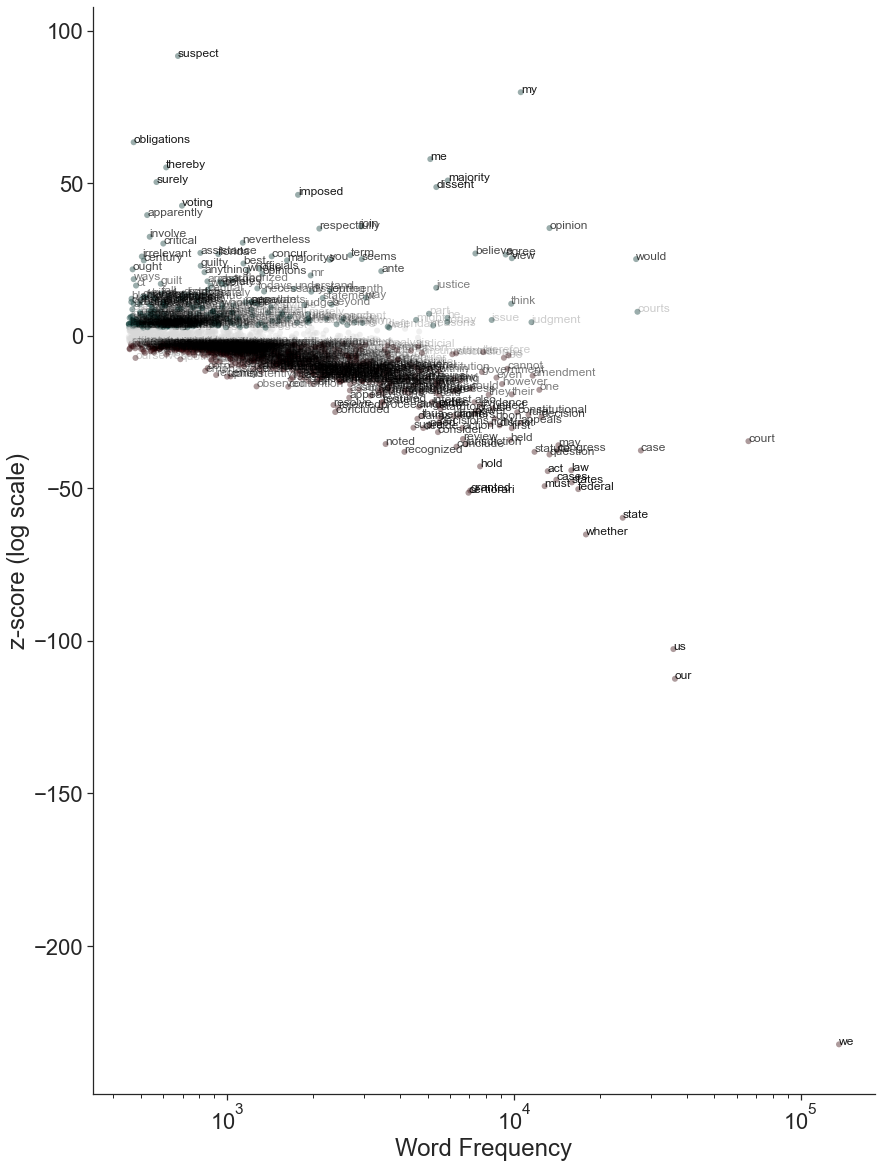

In [102]:
output_list, vocabulary = bayes_compare_language(individualistic_list, collective_list, output_path, prior=vector_prior, cv=vectorizer)
z_scores_df = pd.DataFrame(output_list)

In [103]:
z_scores_df.to_csv(os.path.join(output_path, 'z_scores_fightin_words.csv'))

### Top Cases

In [104]:
df_long_opinion = df[df["length"] >20]

opinion_means = pd.DataFrame(df.groupby(['opinion_num', 'category','author', 'case', 'length', 'year'])['individualistic', 'collective'].mean()).reset_index()
# individualistic_mean = pd.DataFrame(df_long_opinion.groupby(["opinion_num", "case", "category", "year", "author", "length"])["individualistic"].mean())

# collective_mean = pd.DataFrame(df_long_opinion.groupby(["opinion_num", "case", "category", "year", "author", "length"])["collective"].mean())

/var/folders/lp/x4djrvvn0pg2br3sp0y85wkr0000gn/T/ipykernel_96652/841007605.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  opinion_means = pd.DataFrame(df.groupby(['opinion_num', 'category','author', 'case', 'length', 'year'])['individualistic', 'collective'].mean()).reset_index()


In [105]:
# individualistic_mean = individualistic_mean.reset_index()
# collective_mean = collective_mean.reset_index()

In [106]:
# shorter_means = individualistic_mean[individualistic_mean["length"] <= 500]

In [107]:
# longer_opinions = individualistic_mean[individualistic_mean["length"] >= 100]

In [108]:
# long_opinions = longer_opinions.opinion_num.tolist()

In [109]:
opinion_means.sort_values(by = "case")

,opinion_num,category,author,case,length,year,individualistic,collective
9149,9169,Dissenting,Justice Stevens,14 Penn Plaza LLC v. Pyett,39,2009,0.212121,0.242424
9150,9170,Dissenting,Justice Souter,14 Penn Plaza LLC v. Pyett,82,2009,0.052632,0.263158
9148,9168,Majority,Justice Thomas,14 Penn Plaza LLC v. Pyett,297,2009,0.022556,0.090226
1250,1254,Majority,Justice Vinson,149 Madison Ave. Corp. v. Asselta,75,1947,0.000000,0.111111
2310,2316,Dissenting,Justice O'Connor,324 Liquor Corp. v. Duffy,98,1987,0.062500,0.037500
...,...,...,...,...,...,...,...,...
1915,1921,Majority,Justice White,Zurcher v. Stanford Daily,165,1978,0.013605,0.115646
10783,10804,Majority,Justice Brennan,Zwickler v. Koota,103,1967,0.022989,0.160920
10784,10805,Concurring,Justice Harlan,Zwickler v. Koota,22,1967,0.454545,0.045455
14938,14961,Concurring,Justice Roberts,"eBay Inc. v. MERCEXCHANGE, LL",12,2006,0.100000,0.000000


In [110]:
opinion_means[opinion_means["year"] > 2015].sort_values(by = "individualistic", ascending = False).head(100)

,opinion_num,category,author,case,length,year,individualistic,collective
157,157,Concurring,Justice Sotomayor,Wooden v. United States\n,5,2022,1.000000,0.000000
153,153,Concurring,Justice Alito,United States v. Cooley\n,1,2021,1.000000,0.000000
177,177,Concurring,Justice Barrett,"Viking River Cruises, Inc. v. Moriana\n",6,2022,0.800000,0.000000
184,184,Concurring,Justice Breyer,Carr v. Saul,6,2021,0.800000,0.000000
13330,13352,Dissenting,Justice Thomas,"Kindred Nursing Centers, L. P. v. Clark",4,2017,0.666667,0.000000
...,...,...,...,...,...,...,...,...
4907,4918,Dissenting,Justice Thomas,Lozman v. Riviera Beach,97,2018,0.177215,0.063291
8804,8824,Concurring,Justice Thomas,Betterman v. Montana,27,2016,0.173913,0.304348
247,247,Dissenting,Justice Thomas,Van Buren v. United States\n,189,2021,0.173653,0.005988
15115,15138,Concurring,Justice Thomas,Lucia v. SEC,210,2018,0.173184,0.050279


array([[<AxesSubplot:title={'center':'year'}>]], dtype=object)

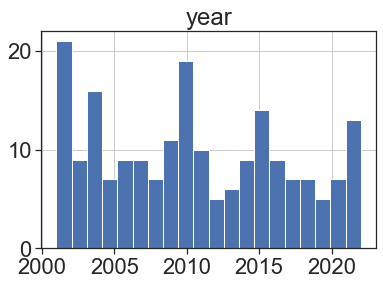

In [111]:

individualistic_majority = opinion_means[opinion_means["category"] == "Majority"]
individualistic_majority[individualistic_majority["year"] > 2000].sort_values(by = "individualistic", ascending=False).head(200).hist("year", bins = 20)

In [112]:
# group by opinion type
# get z score of column
# compare to each other
# sort by z score
from scipy.stats import zscore 

opinion_means["indi_cat_z_score"] = opinion_means.groupby(['category']).individualistic.transform(zscore, ddof=1)
opinion_means["coll_cat_z_score"] = opinion_means.groupby(['category']).collective.transform(zscore, ddof=1)

In [113]:
opinion_means[opinion_means["year"] > 2015].sort_values(by = "indi_cat_z_score", ascending=False).head(50)

,opinion_num,category,author,case,length,year,individualistic,collective,indi_cat_z_score,coll_cat_z_score
1938,1944,Majority,Justice Kennedy,Bethune-Hill v. Virginia State Bd. of Elections,341,2017,0.123377,0.064935,4.667410,-1.196050
153,153,Concurring,Justice Alito,United States v. Cooley\n,1,2021,1.000000,0.000000,4.054283,-0.908113
157,157,Concurring,Justice Sotomayor,Wooden v. United States\n,5,2022,1.000000,0.000000,4.054283,-0.908113
13330,13352,Dissenting,Justice Thomas,"Kindred Nursing Centers, L. P. v. Clark",4,2017,0.666667,0.000000,3.631070,-1.115428
184,184,Concurring,Justice Breyer,Carr v. Saul,6,2021,0.800000,0.000000,2.973042,-0.908113
177,177,Concurring,Justice Barrett,"Viking River Cruises, Inc. v. Moriana\n",6,2022,0.800000,0.000000,2.973042,-0.908113
12666,12688,Majority,Justice Gorsuch,Food Marketing Institute v. Argus Leader Media,199,2019,0.078212,0.122905,2.787663,-0.236295
2786,2794,Dissenting,Justice Gorsuch,Mitchell v. Wisconsin,6,2019,0.500000,0.166667,2.429043,1.119603
10050,10071,Dissenting,Justice Sotomayor,"Janus v. State, County, and Municipal Employees",8,2018,0.500000,0.000000,2.429043,-1.115428
2757,2765,Dissenting,Justice Thomas,Fisher v. University of Tex. at Austin,10,2016,0.500000,0.000000,2.429043,-1.115428


In [114]:
# merge collective_mean and individualistic_mean on opinion_num, create new column that's an average of individualistic and collective scores
# opinion_means_combined = pd.merge(collective_mean, individualistic_mean, on=["opinion_num", "case", "category", "year", "author", "length"]).reset_index()

In [115]:
# opinion_means_combined

In [116]:
def get_column_average(col1, col2):
    individualistic_score = col1
    collective_score = col2
    average_score = (individualistic_score + collective_score) / 2

    return average_score

def get_sum_square_values(col1, col2):
    individualistic_score = col1
    collective_score = col2
    balanced_score = pow(individualistic_score, 2) + pow(collective_score, 2)

    return balanced_score

def add_columns(col1, col2):
    individualistic_score = col1
    collective_score = col2
    added_score = col1 + col2

    return added_score

def get_difference(col1, col2):
    individualistic_score = col1
    collective_score = col2
    difference = abs(col1 - col2)

    return difference

In [117]:
opinion_means["average"] = opinion_means.apply(lambda x: get_column_average(x['individualistic'], x['collective']), axis=1)
opinion_means["balance"] = opinion_means.apply(lambda x: get_sum_square_values(x['individualistic'], x['collective']), axis=1)
opinion_means["added"] = opinion_means.apply(lambda x: add_columns(x['individualistic'], x['collective']), axis=1)
opinion_means["difference"] = opinion_means.apply(lambda x: get_difference(x['individualistic'], x['collective']), axis=1)


In [118]:
pd.set_option('display.max_rows', 100)

In [119]:
opinion_means["len_weighted_indi"] = opinion_means["individualistic"] * np.sqrt(opinion_means["length"])
opinion_means["len_weighted_coll"] = opinion_means["collective"] * np.sqrt(opinion_means["length"])

opinion_means[opinion_means["year"] > 2000].sort_values(by = "len_weighted_indi", ascending = False).head(100)

,opinion_num,category,author,case,length,year,individualistic,collective,indi_cat_z_score,coll_cat_z_score,average,balance,added,difference,len_weighted_indi,len_weighted_coll
13559,13582,Majority,Justice Kennedy,Uttecht v. Brown,507,2007,0.206349,0.068027,8.120744,-1.144856,0.137188,0.047208,0.274376,0.138322,4.646295,1.531746
232,232,Concurring,Justice Kagan,Collins v. Yellen,88,2021,0.441558,0.064935,1.035234,-0.176139,0.253247,0.199190,0.506494,0.376623,4.142185,0.609145
277,277,Dissenting,Justice Kagan,Edwards v. Vannoy,254,2021,0.227273,0.077273,0.462089,-0.079186,0.152273,0.057624,0.304545,0.150000,3.622131,1.231525
6586,6598,Dissenting,Justice Breyer,Horne v. Flores,612,2009,0.135458,0.033865,-0.200092,-0.661298,0.084661,0.019496,0.169323,0.101594,3.351050,0.837762
2322,2328,Concurring,Justice Stevens,Rita v. United States,295,2007,0.194570,0.131222,-0.300036,0.571071,0.162896,0.055077,0.325792,0.063348,3.341852,2.253807
6679,6691,Dissenting,Justice Roberts,Obergefell v. Hodges,404,2015,0.166213,0.092643,0.021713,0.126933,0.129428,0.036209,0.258856,0.073569,3.340831,1.862102
8698,8717,Dissenting,Justice Stevens,McDonald v. Chicago,690,2010,0.123810,0.133333,-0.284104,0.672597,0.128571,0.033107,0.257143,0.009524,3.252210,3.502380
2448,2454,Concurring,Justice Scalia,Skilling v. United States,672,2010,0.120915,0.045752,-0.698230,-0.392382,0.083333,0.016714,0.166667,0.075163,3.134476,1.186018
1764,1770,Concurring,Justice Sotomayor,Hughes v. United States,48,2018,0.450000,0.025000,1.080870,-0.626303,0.237500,0.203125,0.475000,0.425000,3.117691,0.173205
6258,6270,Dissenting,Justice Scalia,James v. United States,180,2007,0.231788,0.112583,0.494655,0.394328,0.172185,0.066401,0.344371,0.119205,3.109763,1.510457


In [120]:
opinion_means[opinion_means["year"] > 2000].sort_values(by = "len_weighted_coll", ascending = False).head(50)

,opinion_num,category,author,case,length,year,individualistic,collective,indi_cat_z_score,coll_cat_z_score,average,balance,added,difference,len_weighted_indi,len_weighted_coll
7945,7962,Dissenting,Justice Roberts,Danforth v. Minnesota,270,2008,0.056410,0.364103,-0.770199,3.767256,0.210256,0.135753,0.420513,0.307692,0.926915,5.982816
7944,7961,Majority,Justice Stevens,Danforth v. Minnesota,286,2008,0.009615,0.288462,-0.067352,2.504672,0.149038,0.083303,0.298077,0.278846,0.162611,4.878327
6116,6128,Dissenting,Justice Alito,Ortiz v. United States,454,2018,0.071429,0.222222,-0.661884,1.864614,0.146825,0.054485,0.293651,0.150794,1.521948,4.734950
12366,12388,Majority,Justice Scalia,Virginia v. Moore,178,2008,0.000000,0.344262,-0.467546,3.428514,0.172131,0.118517,0.344262,0.344262,0.000000,4.593032
7656,7673,Majority,Justice Kagan,Camreta v. Greene,268,2011,0.000000,0.279661,-0.467546,2.358970,0.139831,0.078210,0.279661,0.279661,0.000000,4.578248
9664,9684,Majority,Justice Kennedy,Boumediene v. Bush,1029,2008,0.005938,0.142518,-0.220395,0.088416,0.074228,0.020347,0.148456,0.136580,0.190487,4.571691
1068,1072,Majority,Justice Breyer,United States v. Stitt,133,2018,0.000000,0.390805,-0.467546,4.199072,0.195402,0.152728,0.390805,0.390805,0.000000,4.506978
3354,3363,Dissenting,Justice Breyer,Agency for Int'l Development v. Alliance for Open Society,364,2020,0.076923,0.234114,-0.622257,2.024081,0.155518,0.060726,0.311037,0.157191,1.467599,4.466605
8653,8672,Majority,Justice Alito,South Carolina v. North Carolina,402,2010,0.045455,0.221591,1.424280,1.397557,0.133523,0.051169,0.267045,0.176136,0.911361,4.442884
1421,1426,Majority,Justice Stevens,"Tahoe-Sierra Preservation Council, Inc. v. Tahoe Regional Planning Agency",354,2002,0.003610,0.234657,-0.317293,1.613881,0.119134,0.055077,0.238267,0.231047,0.067924,4.415046


In [121]:
high_means = opinion_means[opinion_means["added"] > .0]
high_means.sort_values('difference', ascending=False).head(50)

,opinion_num,category,author,case,length,year,individualistic,collective,indi_cat_z_score,coll_cat_z_score,average,balance,added,difference,len_weighted_indi,len_weighted_coll
12745,12767,Concurring,Justice Stevens,"Security Services, Inc. v. Kmart Corp.",3,1994,1.000000,0.0,4.054283,-0.908113,0.500000,1.000000,1.000000,1.000000,1.732051,0.000000
13113,13135,Concurring,Justice Ginsburg,Burrage v. United States,6,2014,1.000000,0.0,4.054283,-0.908113,0.500000,1.000000,1.000000,1.000000,2.449490,0.000000
7234,7250,Dissenting,Justice Brennan,California Ex Rel. Cooper v. Mitchell Brothers' Santa Ana Theater,5,1982,1.000000,0.0,6.035124,-1.115428,0.500000,1.000000,1.000000,1.000000,2.236068,0.000000
8493,8512,Concurring,Justice Powell,"Alfred Dunhill of London, Inc. v. Republic of Cuba",6,1976,1.000000,0.0,4.054283,-0.908113,0.500000,1.000000,1.000000,1.000000,2.449490,0.000000
1417,1422,Concurring,Justice Blackmun,"Day & Zimmermann, Inc. v. Challoner",6,1975,1.000000,0.0,4.054283,-0.908113,0.500000,1.000000,1.000000,1.000000,2.449490,0.000000
13575,13598,Concurring,Justice Scalia,"Amerada Hess Corp. v. Director, Div. of Taxation, NJ Dept. of Treasury",6,1989,1.000000,0.0,4.054283,-0.908113,0.500000,1.000000,1.000000,1.000000,2.449490,0.000000
7554,7571,Dissenting,Justice Black,Koehring Co. v. Hyde Constr. Co.,3,1966,1.000000,0.0,6.035124,-1.115428,0.500000,1.000000,1.000000,1.000000,1.732051,0.000000
7515,7532,Concurring,Justice Brennan,Knapp v. Schweitzer,3,1958,1.000000,0.0,4.054283,-0.908113,0.500000,1.000000,1.000000,1.000000,1.732051,0.000000
2005,2011,Dissenting,Justice Harlan,Bloss v. Dykema,5,1970,1.000000,0.0,6.035124,-1.115428,0.500000,1.000000,1.000000,1.000000,2.236068,0.000000
1004,1008,Dissenting,Justice Stewart,First Nat. Bank in Plant City v. Dickinson,5,1969,1.000000,0.0,6.035124,-1.115428,0.500000,1.000000,1.000000,1.000000,2.236068,0.000000


In [122]:
opinion_means[opinion_means["category"] == "Majority"].sort_values(by=['average'], ascending=False).head(200)

,opinion_num,category,author,case,length,year,individualistic,collective,indi_cat_z_score,coll_cat_z_score,average,balance,added,difference,len_weighted_indi,len_weighted_coll
3703,3713,Majority,Justice Rehnquist,Wise v. Lipscomb,5,1978,0.400000,0.400000,16.180523,4.351312,0.400000,0.320000,0.800000,0.000000,0.894427,0.894427
225,225,Majority,Justice Barrett,Florida v. Georgia,8,2021,0.000000,0.571429,-0.467546,7.189498,0.285714,0.326531,0.571429,0.571429,0.000000,1.616244
2694,2702,Majority,Justice Black,Leyra v. Denno,1007,1954,0.443000,0.039000,17.970191,-1.625433,0.241000,0.197770,0.482000,0.404000,14.057836,1.237597
15233,15257,Majority,Justice Stewart,Lynumn v. Illinois,119,1963,0.336364,0.136364,13.531967,-0.013473,0.236364,0.131736,0.472727,0.200000,3.669294,1.487552
13926,13949,Majority,Justice Vinson,Dixon v. Duffy,35,1952,0.000000,0.451613,-0.467546,5.205820,0.225806,0.203954,0.451613,0.451613,0.000000,2.671778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3666,3676,Majority,Justice Black,"First Nat. Bank of Chicago v. United Air Lines, Inc.",53,1952,0.122449,0.163265,4.628802,0.431913,0.142857,0.041649,0.285714,0.040816,0.891442,1.188589
5159,5170,Majority,Justice Clark,Incres SS Co. v. Maritime Workers,46,1963,0.000000,0.285714,-0.467546,2.459189,0.142857,0.081633,0.285714,0.285714,0.000000,1.937809
10480,10501,Majority,Justice Burger,Missouri v. Hunter,89,1983,0.025974,0.259740,0.613497,2.029161,0.142857,0.068140,0.285714,0.233766,0.245038,2.450385
11919,11941,Majority,Justice Clark,FTC v. Standard Oil Co.,56,1958,0.000000,0.285714,-0.467546,2.459189,0.142857,0.081633,0.285714,0.285714,0.000000,2.138090


In [123]:
opinion_means.sort_values(by=['average'], ascending=False).head(100).to_csv(os.path.join(output_path, "top_combined_opinions.csv"))

# Most individualistic or collective cases

In [124]:

case_means = pd.DataFrame(df.groupby(['case', 'year'])['individualistic', 'collective'].mean()).reset_index()


/var/folders/lp/x4djrvvn0pg2br3sp0y85wkr0000gn/T/ipykernel_96652/3479918376.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  case_means = pd.DataFrame(df.groupby(['case', 'year'])['individualistic', 'collective'].mean()).reset_index()


In [125]:
case_means[case_means["year"] > 2000].sort_values("individualistic", ascending=False).head(50)

,case,year,individualistic,collective
7818,Uttecht v. Brown,2007,0.199627,0.093284
8252,Yarborough v. Gentry,2003,0.195946,0.006757
7585,United States v. Ressam,2008,0.190476,0.055556
5537,Pliler v. Ford,2004,0.142857,0.071429
2080,Edwards v. Vannoy,2021,0.130682,0.119318
25,Abdur'Rahman v. Bell,2002,0.128571,0.085714
8278,Youngblood v. West Virginia,2006,0.126582,0.278481
2763,Gonzalez v. United States,2008,0.126183,0.116719
644,Bethune-Hill v. Virginia State Bd. of Elections,2017,0.123377,0.064935
301,Arizona v. Gant,2009,0.118590,0.131410


In [126]:
case_means[case_means["year"] > 2010].sort_values("collective", ascending=False).head(50)

,case,year,individualistic,collective
2457,Florida v. Georgia,2021,0.000000,0.571429
5816,Retirement Plans Comm. of IBM v. Jander,2019,0.000000,0.526316
7669,United States v. Stitt,2018,0.000000,0.390805
7165,United States v. Cooley\n,2021,0.010309,0.340206
6785,"Thompson v. North American Stainless, LP",2011,0.021277,0.319149
5540,Plumhoff v. Rickard,2014,0.000000,0.313725
8195,Wittman v. Personhuballah,2016,0.000000,0.285714
5872,Rippo v. Baker,2016,0.000000,0.277778
232,"Americold Realty Trust v. ConAgra Foods, Inc.",2016,0.014493,0.275362
2831,Greene v. Fisher,2011,0.000000,0.266667


## Label Relationships

In [127]:
import os
import matplotlib.pyplot as plt
output_path = os.path.join(os.getcwd(), 'individualistic_vs_collective')

In [128]:
import plotly.graph_objects as go

fig = go.Figure(go.Treemap(
    labels = ["All Sentences", "Not Rhetoric","Rhetoric", "Monologic", "Not Monologic", "Individualistic", "Collective"],
    parents = ["", "All Sentences", "All Sentences", "Rhetoric", "Rhetoric", "Monologic", "Monologic"],
    values = [100,54, 46, 19, 27, 5, 14],
    branchvalues="total",
    marker_colors = ["#a8a1a1", "#c1bcbc", "#c1bcbc", "#d9d6d6", "#d9d6d6", "white", "white"]
))

fig.update_layout(width=900,height=500,margin = dict(t=25, l=25, r=25, b=25), uniformtext=dict(minsize=12, mode = 'hide'))
fig.data[0]['textfont']['color'] = "black"
plt.savefig(os.path.join(output_path, 'treemap.png'), dpi = 600)
fig.show()

<Figure size 432x288 with 0 Axes>

## Seniority and Salience

In [129]:
martin_quinn = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'martin_quinn.csv'))
salience_df = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'all_metadata.csv'))

/var/folders/lp/x4djrvvn0pg2br3sp0y85wkr0000gn/T/ipykernel_96652/3138088188.py:2: DtypeWarning:

Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.



In [130]:
martin_quinn_mean = pd.DataFrame(martin_quinn.groupby(["justiceName"])["post_mn"].mean())
scd_list_names = list(martin_quinn_mean.index)

In [131]:
# create justice matcher
def match_scd_author(df_col):
    if df_col == "Justice O'Connor":
        scd_name = "SDOConnor"
    elif df_col == "Justice Black":
        scd_name = "HLBlack"
    elif df_col == "Justice Roberts":
        scd_name = "JGRoberts"
    else:
        match = re.search(r'Justice (\S+)', df_col)
        last_name = match.group(1)
        name = list(filter(lambda x: last_name in x, scd_list_names))
        scd_name = ''.join(name)

    return scd_name


In [132]:
per_curiam = ["per_curiam", "Justice Vinson"]
df_filtered = df[~df['author'].isin(per_curiam)]
df_filtered = df_filtered.drop(df_filtered[(df_filtered['author'] == "Justice Jackson") & (df_filtered['year'] == 1964)].index)


df_indi = df_filtered.groupby(['opinion_num', 'category','author', 'case', 'year'])['individualistic'].mean().reset_index()
df_collective = df_filtered.groupby(['opinion_num', 'category','author', 'case', 'year'])['collective'].mean().reset_index()


In [133]:
df_indi_author = df_indi.groupby(['author'])['individualistic'].mean().reset_index()
df_coll_author = df_collective.groupby(['author'])['collective'].mean().reset_index()

In [134]:
author_mean = pd.merge(df_indi_author, df_coll_author, on = "author")

In [135]:
# ideology
#author_mean = author_mean.reset_index()
author_mean["scd_name"] = author_mean.apply(lambda row: match_scd_author(row["author"]),axis=1)

In [136]:
from scipy.stats import pearsonr
martin_quinn_mean = martin_quinn_mean.reset_index()
# merge df and martin_quinn_ave
justice_monologic_ideology = author_mean.merge(martin_quinn_mean, left_on = "scd_name", right_on = "justiceName")
individualistic_array = justice_monologic_ideology["individualistic"].array
collective_array = justice_monologic_ideology["collective"].array
ideology_array = justice_monologic_ideology["post_mn"].array
coll_corr, coll_sig = pearsonr(collective_array, ideology_array)

indi_corr, indi_sig = pearsonr(individualistic_array, ideology_array)


In [137]:
print("Collective correlation: "+ str(coll_corr) + " with a significance of " + str(coll_sig))
print("Individualistic correlation: "+ str(indi_corr) + " with a significance of " + str(indi_sig))

Collective correlation: 0.2868799333440451 with a significance of 0.08515575833803907
Individualistic correlation: 0.05356222167847183 with a significance of 0.7528756347026342


**Takeaway:** Overall, the collective tone is more correlated with conservative ideology, but neither of these are significant.

In [138]:
# Ideology by year

indi_by_year = df_filtered.groupby(["author", "year", "chief_justice"], as_index=False)["individualistic"].mean()
coll_by_year = df_filtered.groupby(["author", "year", "chief_justice"], as_index=False)["collective"].mean()

author_by_year = pd.merge(indi_by_year, coll_by_year, on = ["author", "year", "chief_justice"])
author_by_year["scd_name"] = author_by_year.apply(lambda row: match_scd_author(row["author"]),axis=1)

In [139]:
author_by_year

,author,year,chief_justice,individualistic,collective,scd_name
0,Justice Alito,2006,Roberts,0.038866,0.114496,SAAlito
1,Justice Alito,2007,Roberts,0.024038,0.125000,SAAlito
2,Justice Alito,2008,Roberts,0.065601,0.105292,SAAlito
3,Justice Alito,2009,Roberts,0.033333,0.106667,SAAlito
4,Justice Alito,2010,Roberts,0.039095,0.109208,SAAlito
...,...,...,...,...,...,...
697,Justice Whittaker,1958,Warren,0.051262,0.084927,CEWhittaker
698,Justice Whittaker,1959,Warren,0.038079,0.105960,CEWhittaker
699,Justice Whittaker,1960,Warren,0.084980,0.069170,CEWhittaker
700,Justice Whittaker,1961,Warren,0.051737,0.074903,CEWhittaker


In [140]:
year_monologic_ideology = pd.merge(author_by_year, martin_quinn,  how='left', left_on=['scd_name','year'], right_on = ['justiceName','term'])

In [141]:
year_monologic_ideology

,author,year,chief_justice,individualistic,collective,scd_name,term,justice,justiceName,post_mn,post_sd,post_med,post_025,post_975
0,Justice Alito,2006,Roberts,0.038866,0.114496,SAAlito,2006.0,112.0,SAAlito,1.465,0.296,1.454,0.921,2.085
1,Justice Alito,2007,Roberts,0.024038,0.125000,SAAlito,2007.0,112.0,SAAlito,1.559,0.295,1.541,1.007,2.155
2,Justice Alito,2008,Roberts,0.065601,0.105292,SAAlito,2008.0,112.0,SAAlito,1.817,0.290,1.812,1.278,2.410
3,Justice Alito,2009,Roberts,0.033333,0.106667,SAAlito,2009.0,112.0,SAAlito,1.855,0.309,1.848,1.274,2.490
4,Justice Alito,2010,Roberts,0.039095,0.109208,SAAlito,2010.0,112.0,SAAlito,1.996,0.324,1.995,1.373,2.642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,Justice Whittaker,1958,Warren,0.051262,0.084927,CEWhittaker,1958.0,93.0,CEWhittaker,1.286,0.214,1.280,0.889,1.718
698,Justice Whittaker,1959,Warren,0.038079,0.105960,CEWhittaker,1959.0,93.0,CEWhittaker,1.370,0.213,1.366,0.969,1.793
699,Justice Whittaker,1960,Warren,0.084980,0.069170,CEWhittaker,1960.0,93.0,CEWhittaker,1.209,0.235,1.204,0.766,1.692
700,Justice Whittaker,1961,Warren,0.051737,0.074903,CEWhittaker,1961.0,93.0,CEWhittaker,1.147,0.333,1.136,0.523,1.815


In [142]:
year_monologic_ideology = year_monologic_ideology.dropna()

In [143]:
corr_indi_year, sig_indi_year = pearsonr(year_monologic_ideology["individualistic"].array, year_monologic_ideology["post_mn"].array)
corr_coll_year, sig_coll_year = pearsonr(year_monologic_ideology["collective"].array, year_monologic_ideology["post_mn"].array)

In [144]:
print("Correlation between ideology and individualistic tone, by year: "+ str(round(corr_indi_year, 3)) + " with a significance of " + str(round(sig_indi_year, 3)))
print("Correlation between ideology and collective tone, by year: "+ str(round(corr_coll_year, 3)) + " with a significance of " + str(round(sig_coll_year, 5)))

Correlation between ideology and individualistic tone, by year: -0.038 with a significance of 0.335
Correlation between ideology and collective tone, by year: 0.165 with a significance of 2e-05


**Takeaway:** There is a slight positive correlation between conservative ideology and collective tone, by year. This is a significant finding. 

In [145]:
# by CJ
year_monologic_ideology.groupby('chief_justice')[['individualistic','post_mn']].corr()

individualistic   post_mn
chief_justice                                           
Burger        individualistic         1.000000 -0.180149
              post_mn                -0.180149  1.000000
Rehnquist     individualistic         1.000000  0.036884
              post_mn                 0.036884  1.000000
Roberts       individualistic         1.000000  0.241194
              post_mn                 0.241194  1.000000
Vinson        individualistic         1.000000 -0.204695
              post_mn                -0.204695  1.000000
Warren        individualistic         1.000000 -0.006513
              post_mn                -0.006513  1.000000

In [146]:
year_monologic_ideology.groupby('chief_justice')[['collective','post_mn']].corr()

collective   post_mn
chief_justice                                 
Burger        collective    1.000000  0.240050
              post_mn       0.240050  1.000000
Rehnquist     collective    1.000000  0.359260
              post_mn       0.359260  1.000000
Roberts       collective    1.000000  0.076749
              post_mn       0.076749  1.000000
Vinson        collective    1.000000  0.187802
              post_mn       0.187802  1.000000
Warren        collective    1.000000 -0.149392
              post_mn      -0.149392  1.000000

In [147]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 7)
    return pvalues

In [148]:
year_monologic_ideology.groupby('chief_justice')[['collective','post_mn']].apply(calculate_pvalues)

collective   post_mn
chief_justice                                
Burger        collective        0.0   0.00299
              post_mn       0.00299       0.0
Rehnquist     collective        0.0  0.000004
              post_mn      0.000004       0.0
Roberts       collective        0.0  0.381745
              post_mn      0.381745       0.0
Vinson        collective        0.0  0.134109
              post_mn      0.134109       0.0
Warren        collective        0.0  0.073917
              post_mn      0.073917       0.0

In [149]:
year_monologic_ideology.groupby('chief_justice')[['individualistic','post_mn']].apply(calculate_pvalues)

individualistic   post_mn
chief_justice                                          
Burger        individualistic             0.0  0.026866
              post_mn                0.026866       0.0
Rehnquist     individualistic             0.0   0.64544
              post_mn                 0.64544       0.0
Roberts       individualistic             0.0  0.005336
              post_mn                0.005336       0.0
Vinson        individualistic             0.0  0.101912
              post_mn                0.101912       0.0
Warren        individualistic             0.0  0.938246
              post_mn                0.938246       0.0

**Takeaways:** 
* There is slight positive correlation (0.21) between conservative ideology and individualistic tone in the Roberts Court. This is not significant. 
* There is no correlation (0.03) between conservative ideology and collective tone in the Roberts Court. This is not significant.
* There is a higher (0.37) correlation between the Rehnquist Court's collective tone and conservative ideology. This is significant.
* There is no correlation (0.04) between the Rehnquist Court's individualistic tone and conservative ideology. This is significant. 

## Seniority

In [150]:
first_year_df = pd.DataFrame(df_filtered.groupby("author")["year"].min()).reset_index()
first_year_df = first_year_df.rename(columns={"year":"first_year"})
seniority_year = author_by_year.merge(first_year_df, on = "author")

In [151]:
seniority_year["year_on_court"] = seniority_year["year"] - seniority_year["first_year"]
seniority_year

,author,year,chief_justice,individualistic,collective,scd_name,first_year,year_on_court
0,Justice Alito,2006,Roberts,0.038866,0.114496,SAAlito,2006,0
1,Justice Alito,2007,Roberts,0.024038,0.125000,SAAlito,2006,1
2,Justice Alito,2008,Roberts,0.065601,0.105292,SAAlito,2006,2
3,Justice Alito,2009,Roberts,0.033333,0.106667,SAAlito,2006,3
4,Justice Alito,2010,Roberts,0.039095,0.109208,SAAlito,2006,4
...,...,...,...,...,...,...,...,...
697,Justice Whittaker,1958,Warren,0.051262,0.084927,CEWhittaker,1957,1
698,Justice Whittaker,1959,Warren,0.038079,0.105960,CEWhittaker,1957,2
699,Justice Whittaker,1960,Warren,0.084980,0.069170,CEWhittaker,1957,3
700,Justice Whittaker,1961,Warren,0.051737,0.074903,CEWhittaker,1957,4


In [152]:
sen_coll_corr, sen_coll_sig = pearsonr(seniority_year["collective"].array, seniority_year["year_on_court"].array)
sen_indi_corr, sen_indi_sig = pearsonr(seniority_year["individualistic"].array, seniority_year["year_on_court"].array)

print("Correlation between seniority and collective tone: " + str(sen_coll_corr) + " with a significance of " + str(sen_coll_sig))
print("Correlation between seniority and individualitic tone: " + str(sen_indi_corr) + " with a significance of " + str(sen_indi_sig))

Correlation between seniority and collective tone: 0.0073467855610094435 with a significance of 0.8459324595712738
Correlation between seniority and individualitic tone: 0.054498384135980946 with a significance of 0.14917576449086262


**Takeaway:** There is no correlation between seniority and collective or individualistic tones. 

## Salience

In [153]:
salience_df

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0_x,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,...,Unnamed: 0_y,salienceData.caseId,salience.est,salience.sd,early.salience.est,early.salience.sd,probit.salience.est,probit.salience.sd,nytSalience,cqSalience
0,0,0,1555,1955-001,1955-001-01,1955-001-01-01,1955-001-01-01-01,10/10/1955,2,350 U.S. 1,...,1,1955-001,-0.482810,0.818406,-0.190841,0.885945,-0.500808,0.799667,0,0
1,1,1,1556,1955-002,1955-002-01,1955-002-01-01,1955-002-01-01-01,10/17/1955,2,350 U.S. 3,...,2,1955-002,-0.419444,0.810166,-0.232832,0.904265,-0.508252,0.785026,0,0
2,2,2,1557,1955-004,1955-004-01,1955-004-01-01,1955-004-01-01-01,11/7/1955,1,350 U.S. 11,...,4,1955-004,-0.459178,0.822925,-0.265416,0.901517,-0.498846,0.784875,1,0
3,3,3,1558,1955-004,1955-004-01,1955-004-01-01,1955-004-01-01-01,11/7/1955,1,350 U.S. 11,...,4,1955-004,-0.459178,0.822925,-0.265416,0.901517,-0.498846,0.784875,1,0
4,4,4,1559,1955-004,1955-004-01,1955-004-01-01,1955-004-01-01-01,11/7/1955,1,350 U.S. 11,...,4,1955-004,-0.459178,0.822925,-0.265416,0.901517,-0.498846,0.784875,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12605,12605,12605,14165,2008-081,2008-081-01,2008-081-01-01,2008-081-01-01-01,6/25/2009,1,557 U.S. 433,...,7179,2008-081,0.487528,0.492451,0.501604,0.561179,0.701541,0.438540,0,0
12606,12606,12606,14166,2008-082,2008-082-01,2008-082-01-01,2008-082-01-01-01,6/29/2009,1,557 U.S. 519,...,7180,2008-082,-0.854459,0.746576,-0.652630,0.779601,-0.923974,0.676330,0,0
12607,12607,12607,14167,2008-083,2008-083-01,2008-083-01-01,2008-083-01-01-01,6/29/2009,1,557 U.S. 557,...,7181,2008-083,2.625259,0.214877,2.323859,0.250203,2.987232,0.528275,1,1
12608,12608,12608,14168,2008-083,2008-083-01,2008-083-01-01,2008-083-01-01-01,6/29/2009,1,557 U.S. 557,...,7181,2008-083,2.625259,0.214877,2.323859,0.250203,2.987232,0.528275,1,1


In [154]:
df_for_merging = salience_df[['case_name', 'salience.est', 'nytSalience', 'cqSalience']]
df_for_merging = df_for_merging.drop_duplicates()

In [155]:
opinion_individualistic = df.groupby(['case', 'year', 'chief_justice'], as_index=False)['individualistic'].mean()
opinion_collective = df.groupby(['case', 'year','chief_justice'], as_index=False)['collective'].mean()


In [156]:
salience_individualistic_opinion = opinion_individualistic.merge(df_for_merging, left_on = "case", right_on = "case_name")
salience_collective_opinion = opinion_collective.merge(df_for_merging, left_on = "case", right_on = "case_name")


In [157]:
non_salient_individualistic = salience_individualistic_opinion[salience_individualistic_opinion['nytSalience'] == 0]['individualistic']
salient_individualistic = salience_individualistic_opinion[salience_individualistic_opinion['nytSalience'] == 1]['individualistic']

non_salient_collective = salience_collective_opinion[salience_collective_opinion['nytSalience'] == 0]['collective']
salient_collective = salience_collective_opinion[salience_collective_opinion['nytSalience'] == 1]['collective']

In [158]:
import scipy.stats as stats
stats.ttest_ind(non_salient_individualistic, salient_individualistic)

Ttest_indResult(statistic=-6.963186238551718, pvalue=3.6232943025870838e-12)

In [159]:
stats.ttest_ind(non_salient_collective, salient_collective)

Ttest_indResult(statistic=0.6285720123293456, pvalue=0.5296494255558206)

In [160]:
import researchpy as rp
rp.ttest(non_salient_individualistic, salient_individualistic)[0]

/Users/rosamondthalken/opt/anaconda3/lib/python3.8/site-packages/researchpy/ttest.py:18: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,individualistic,6193.0,0.045985,0.051803,0.000658,0.044694,0.047275
1,individualistic,938.0,0.058400,0.044371,0.001449,0.055556,0.061243
2,combined,7131.0,0.047618,0.051058,0.000605,0.046432,0.048803


In [161]:
rp.ttest(non_salient_individualistic, salient_individualistic)[1]

/Users/rosamondthalken/opt/anaconda3/lib/python3.8/site-packages/researchpy/ttest.py:18: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Independent t-test,results
0,Difference (individualistic - individualistic) =,-0.0124
1,Degrees of freedom =,7129.0000
2,t =,-6.9632
3,Two side test p value =,0.0000
4,Difference < 0 p value =,0.0000
5,Difference > 0 p value =,1.0000
6,Cohen's d =,-0.2440
7,Hedge's g =,-0.2439
8,Glass's delta =,-0.2397
9,Pearson's r =,0.0822


In [162]:
rp.ttest(non_salient_collective, salient_collective)[0]

/Users/rosamondthalken/opt/anaconda3/lib/python3.8/site-packages/researchpy/ttest.py:18: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,collective,6193.0,0.124536,0.065008,0.000826,0.122917,0.126156
1,collective,938.0,0.123143,0.050093,0.001636,0.119934,0.126353
2,combined,7131.0,0.124353,0.063246,0.000749,0.122885,0.125821


In [163]:
rp.ttest(non_salient_collective, salient_collective)[1]

/Users/rosamondthalken/opt/anaconda3/lib/python3.8/site-packages/researchpy/ttest.py:18: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Independent t-test,results
0,Difference (collective - collective) =,0.0014
1,Degrees of freedom =,7129.0000
2,t =,0.6286
3,Two side test p value =,0.5296
4,Difference < 0 p value =,0.7352
5,Difference > 0 p value =,0.2648
6,Cohen's d =,0.0220
7,Hedge's g =,0.0220
8,Glass's delta =,0.0214
9,Pearson's r =,0.0074


**Takeaway:** I *think* the individualistic tone is used more often in salient cases, with statistical significance. High (maybe?) t, cohen's d.

## Division and Unanimity

In [164]:
votes_df = salience_df[["case_name", "scdb_votes_majority", "scdb_votes_minority"]]

In [165]:
def check_if_unanimous(df_col):
    if(df_col == 0):
        return 1
    else:
        return 0

votes_df["unanimous"] = votes_df["scdb_votes_minority"].apply(check_if_unanimous)

/var/folders/lp/x4djrvvn0pg2br3sp0y85wkr0000gn/T/ipykernel_96652/1431104803.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [166]:
Counter(votes_df.scdb_votes_minority)

Counter({0.0: 3265, 3.0: 2937, 2.0: 2253, 4.0: 2574, 1.0: 1581})

In [167]:
# get correlation between a case's overall individualistic count and the number of minority votes

division_individualistic_opinion = opinion_individualistic.merge(votes_df, left_on = "case", right_on = "case_name").drop_duplicates()
division_collective_opinion = opinion_collective.merge(votes_df, left_on = "case", right_on = "case_name").drop_duplicates()

In [168]:
minority_votes_by_year = division_individualistic_opinion.groupby('year')["scdb_votes_minority"].mean().array
individualistic_by_year = division_individualistic_opinion.groupby('year')['individualistic'].mean().array
collective_by_year = division_collective_opinion.groupby('year')['collective'].mean().array

In [169]:
pearsonr(minority_votes_by_year, individualistic_by_year)

(-0.027563680783879285, 0.814407649418875)

In [170]:
pearsonr(minority_votes_by_year, collective_by_year)

(-0.29037550286476277, 0.011497763982938416)

In [171]:
print("Correlation between divided decisions and the collective tone: " + str(pearsonr(division_collective_opinion.collective.array, division_collective_opinion.scdb_votes_minority.array)))

Correlation between divided decisions and the collective tone: (-0.11667695173222165, 1.134666108492206e-22)


In [172]:
print("Correlation between divided decisions and the individualistic tone: " + str(pearsonr(division_individualistic_opinion.individualistic.array, division_individualistic_opinion.scdb_votes_minority.array)))

Correlation between divided decisions and the individualistic tone: (0.33537719160264745, 8.411816938039831e-184)


**Takeaways:** 
* With significance, there is positive correlation between division and the individualistic tone.
* With significance, there is negative correlation between division and the collective tone.

In [173]:
unanimous_by_year = division_individualistic_opinion.groupby('year')['unanimous'].mean().array



In [174]:
print("Correlation between unanimity and the individualistic tone: " + str(pearsonr(unanimous_by_year, individualistic_by_year)))

Correlation between unanimity and the individualistic tone: (-0.02844947935511985, 0.8085550265701497)


In [175]:
print("Correlation between unanimity and the collective tone: " + str(pearsonr(unanimous_by_year, collective_by_year)))

Correlation between unanimity and the collective tone: (0.2211967199725788, 0.05650222504869083)


**Takeaway:**
* Insignificant differences with unanimity and the individualistic tone. 
* Significant positive correlation between unanimity and the collective tone. 

## Stimson's Mood

In [176]:
working_dir = os.getcwd()
stimson = pd.read_csv(os.path.join(working_dir, 'Data', 'stimson_mood.csv'))

In [177]:
stimson = stimson[["Year", "Mood2020"]]

In [178]:
individualistic_df = pd.DataFrame(division_individualistic_opinion.groupby('year')["individualistic"].mean())
collective_df = pd.DataFrame(division_collective_opinion.groupby('year')["collective"].mean())

combined_by_year = individualistic_df.merge(collective_df, on = "year")


In [179]:
stimson_combined_df = combined_by_year.merge(stimson, left_on="year", right_on = "Year")

In [180]:
stimson_mood = stimson_combined_df.Mood2020.array
individualistic_mood = stimson_combined_df.individualistic.array
collective_mood = stimson_combined_df.collective.array

In [181]:
pearsonr(stimson_mood, individualistic_mood)

(-0.28956807559210446, 0.016614576647066316)

In [182]:
pearsonr(stimson_mood, collective_mood)

(0.2317564933980307, 0.05721554709654679)